In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import os
import scipy as sp
import xgboost as xgb
import lightgbm as lgb
import itertools
import operator
import warnings
warnings.filterwarnings("ignore")
from scipy import stats 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.externals import joblib
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")


plot = True

goal = 'price'
myid = 'SaleID'


Pretty printing has been turned OFF


<font color='red'>待优化：</font>

- brand未做处理
- 分桶粗糙
- 损失函数
- 其他算法跑

# 导入数据

In [2]:
train = pd.read_csv('../data/used_car_train_20200313.csv',sep=' ', parse_dates=['regDate', 'creatDate'])
train.head(2)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522


In [3]:
testA = pd.read_csv('../data/used_car_testA_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'])
testA.head(2)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,...,0.264405,0.1218,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,...,0.261745,0.0000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055


# 数据初探

## 数据缺失情况

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null object
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null datetime64[ns]
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64


In [6]:
testA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null object
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null datetime64[ns]
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                 

## name列

In [7]:
name_col = train['name'].value_counts().reset_index(inplace=False)
name_col.columns = ['name', 'hit']
name_col
# bodyType_col = name_col.sort_values(['hit'], ascending = False)
# name_col.plot.bar(x="name", y="hit")

,name,hit
0,708,282
1,387,282
2,55,280
3,1541,263
4,203,233
...,...,...
99657,5074,1
99658,7123,1
99659,11221,1
99660,13270,1


## mode列

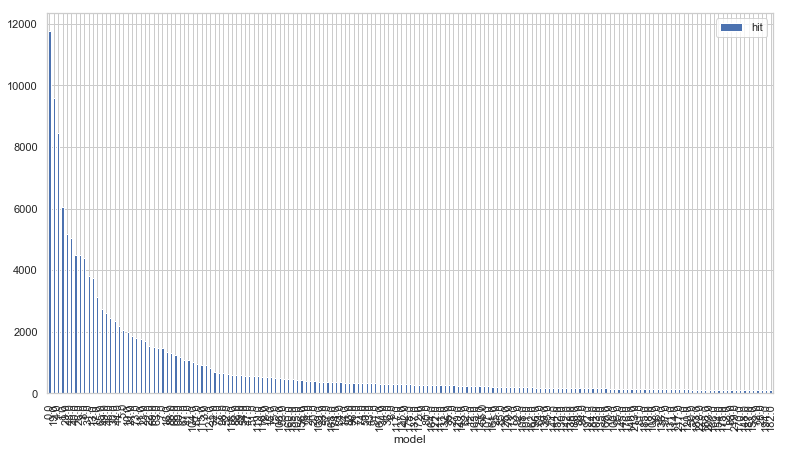

In [8]:
model_col = train['model'].value_counts().reset_index(inplace=False)
model_col.columns = ['model', 'hit']
model_col = model_col.sort_values(['hit'], ascending = False)
model_col.loc[model_col['hit']>100].plot.bar(x="model", y="hit")

## brand列

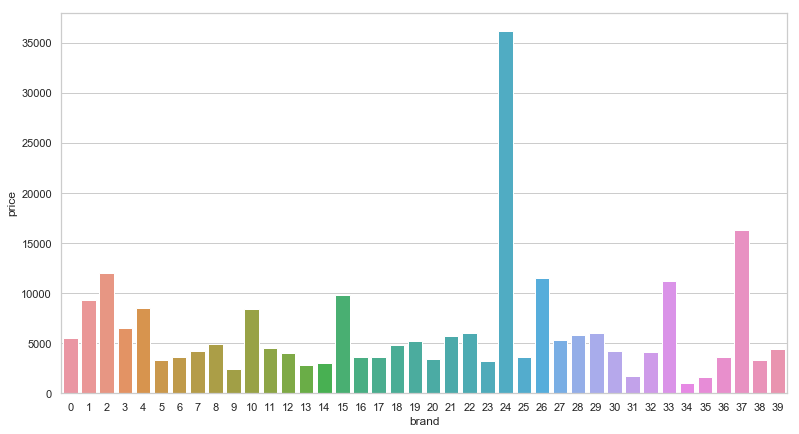

In [9]:
a = train[['brand', 'price']].groupby(['brand']).mean().reset_index()
sns.barplot(x='brand', y= 'price', data=a)

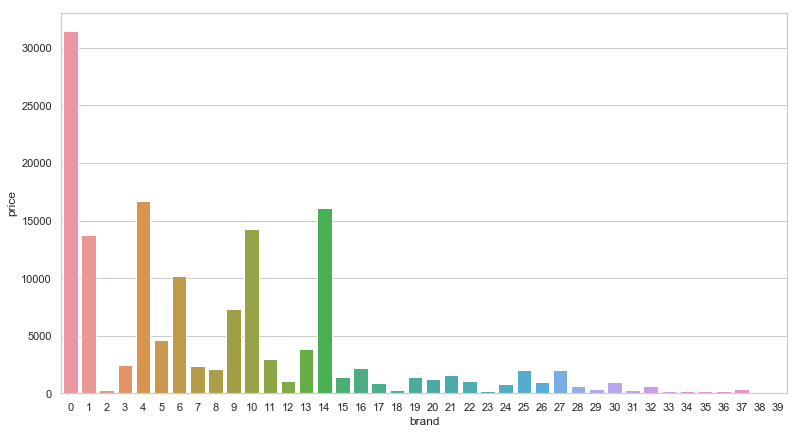

In [10]:
b = train[['brand', 'price']].groupby(['brand']).count().reset_index()
sns.barplot(x='brand', y= 'price', data=b)

## bodyType列

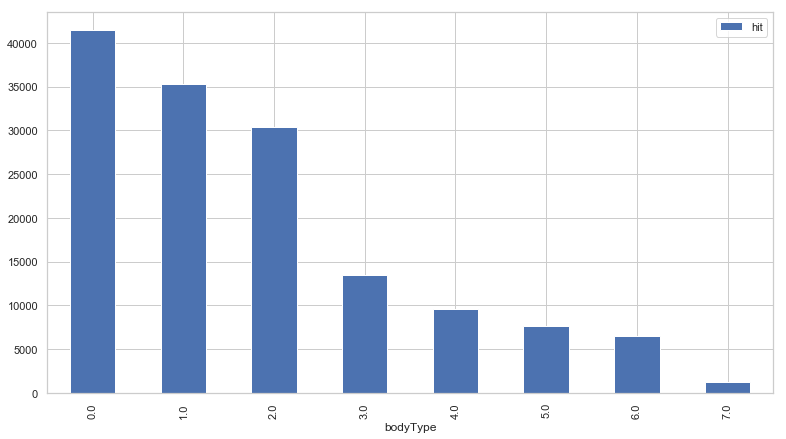

In [11]:
bodyType_col = train['bodyType'].value_counts().reset_index(inplace=False)
bodyType_col.columns = ['bodyType', 'hit']
# bodyType_col = bodyType_col.sort_values(['hit'], ascending = False)
bodyType_col.plot.bar(x="bodyType", y="hit")

## regionCode列

In [12]:
regionCode_col = train['regionCode'].value_counts().reset_index(inplace=False)
regionCode_col.columns = ['regionCode', 'regionCode_count']
regionCode_col

,regionCode,regionCode_count
0,419,369
1,764,258
2,125,137
3,176,136
4,462,134
...,...,...
7900,6414,1
7901,7063,1
7902,4239,1
7903,5931,1


## 价格分布

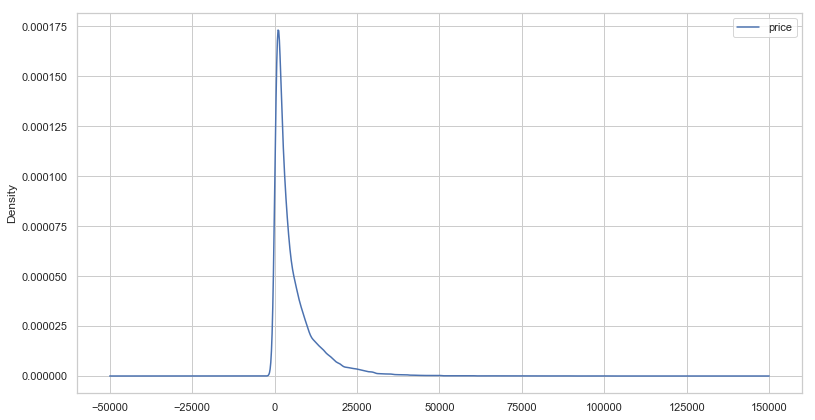

In [13]:
train[['price']].plot.density()

## brand与price的关系

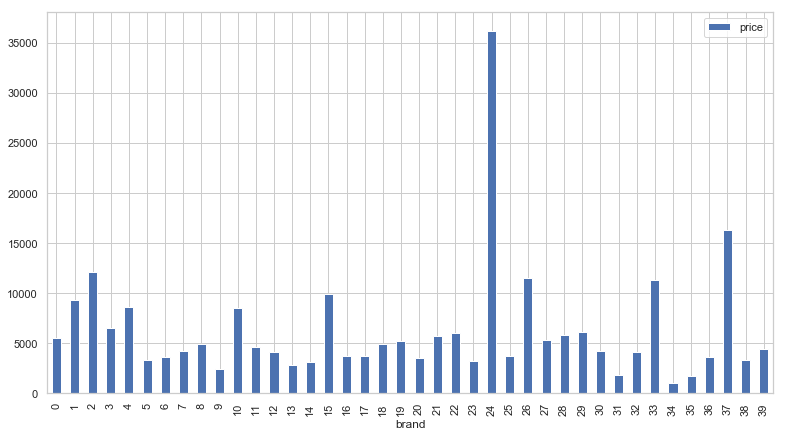

In [15]:
train[['brand','price']].groupby(by=['brand']).mean().plot.bar()

## kilometer

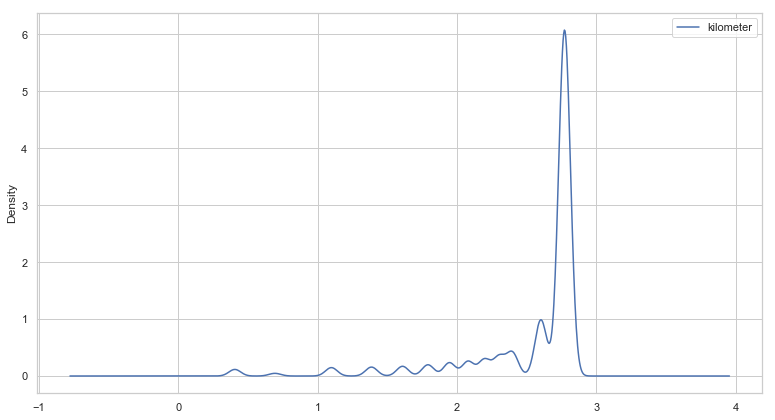

In [16]:
train[['kilometer']].apply(lambda x: np.log(1+x)).plot.density()

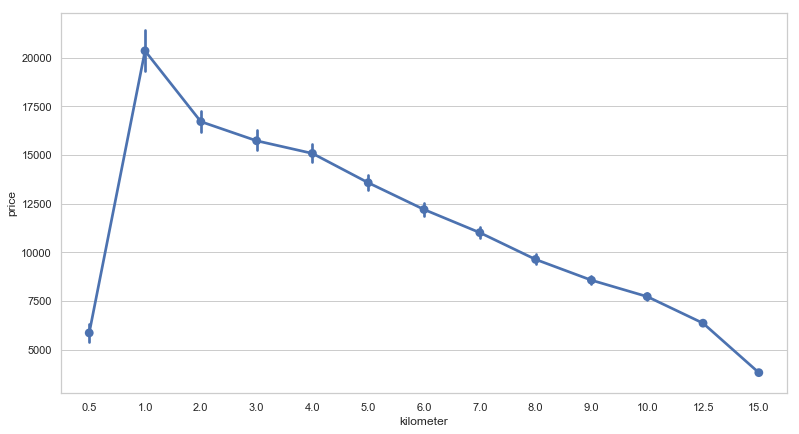

In [17]:
sns.pointplot(x='kilometer', y='price', data=train[['kilometer','price']])

## fuelType

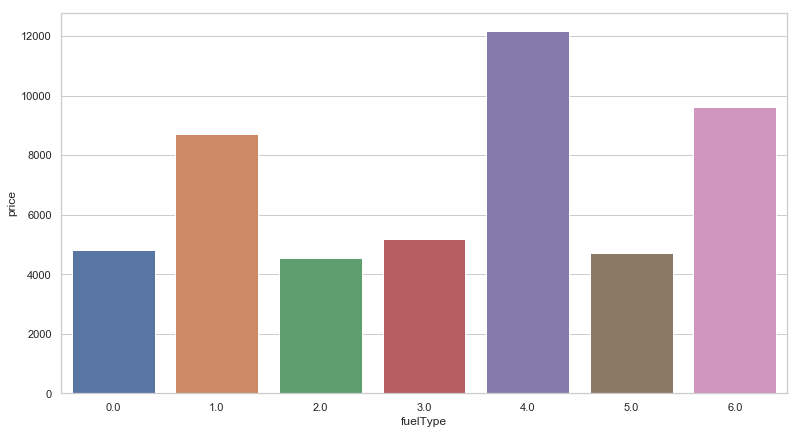

In [18]:
a = train[['fuelType', 'price']].groupby(['fuelType']).mean().reset_index()
sns.barplot(x='fuelType', y= 'price', data=a)

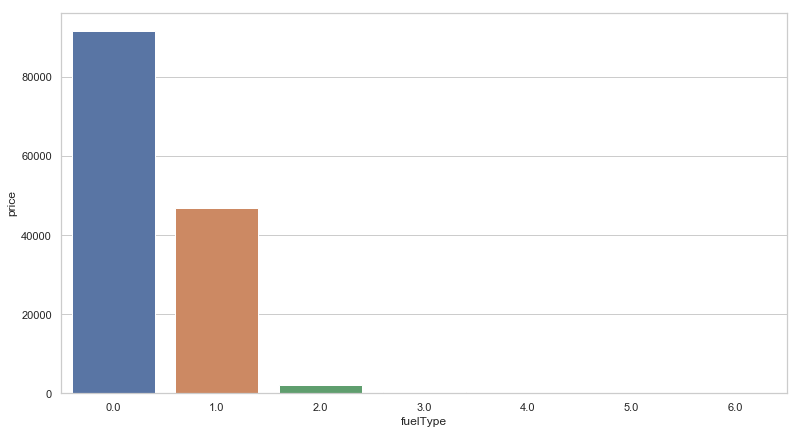

In [19]:
b = train[['fuelType', 'price']].groupby(['fuelType']).count().reset_index()
sns.barplot(x='fuelType', y= 'price', data=b)

## bodyType

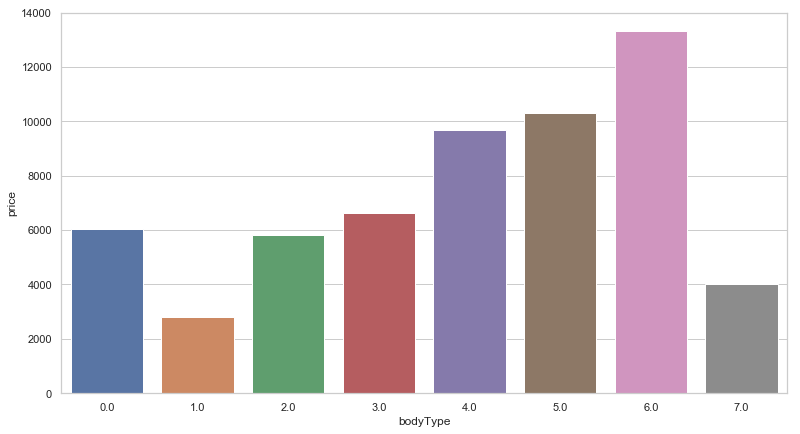

In [20]:
a = train[['bodyType', 'price']].groupby(['bodyType']).mean().reset_index()
sns.barplot(x='bodyType', y= 'price', data=a)

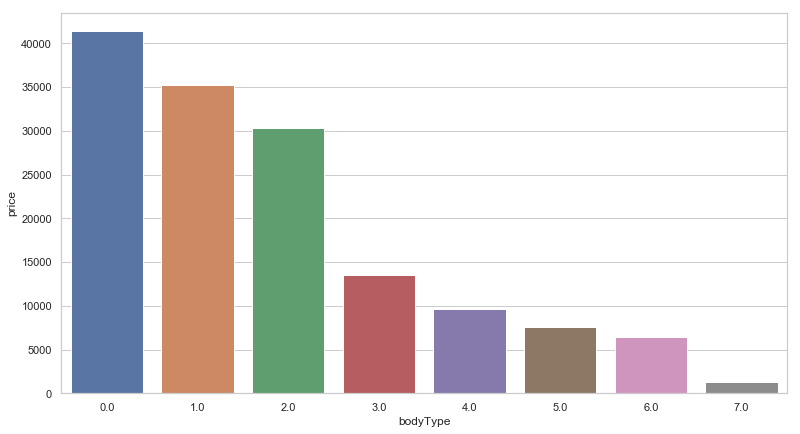

In [21]:
b = train[['bodyType', 'price']].groupby(['bodyType']).count().reset_index()
sns.barplot(x='bodyType', y= 'price', data=b)

## seller

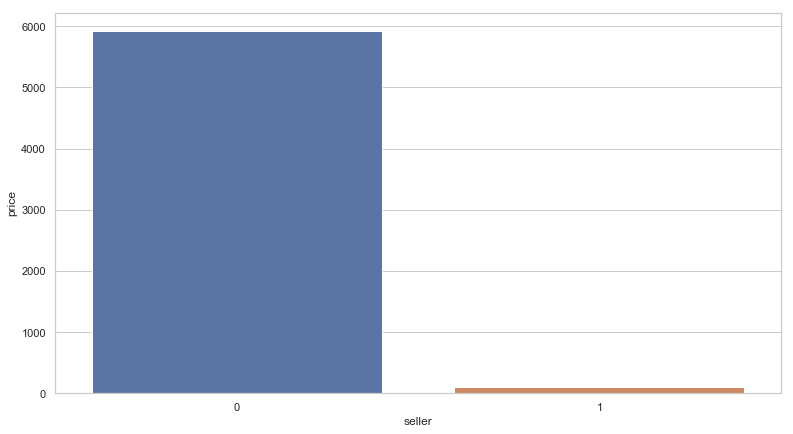

In [22]:
a = train[['seller', 'price']].groupby(['seller']).mean().reset_index()
sns.barplot(x='seller', y= 'price', data=a)

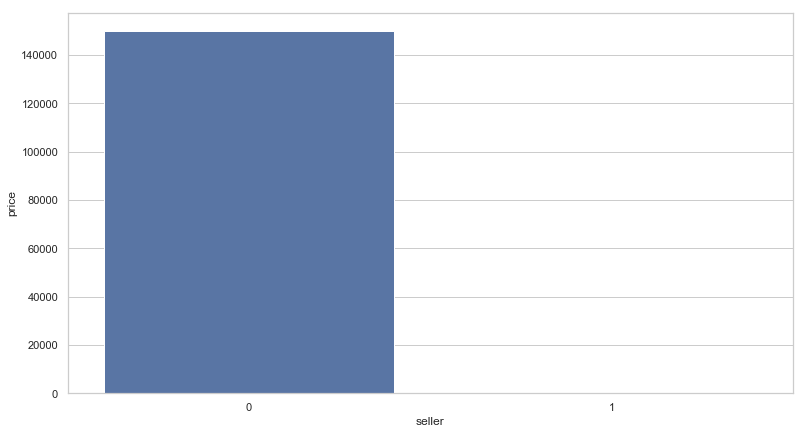

In [23]:
b = train[['seller', 'price']].groupby(['seller']).count().reset_index()
sns.barplot(x='seller', y= 'price', data=b)

## offerType

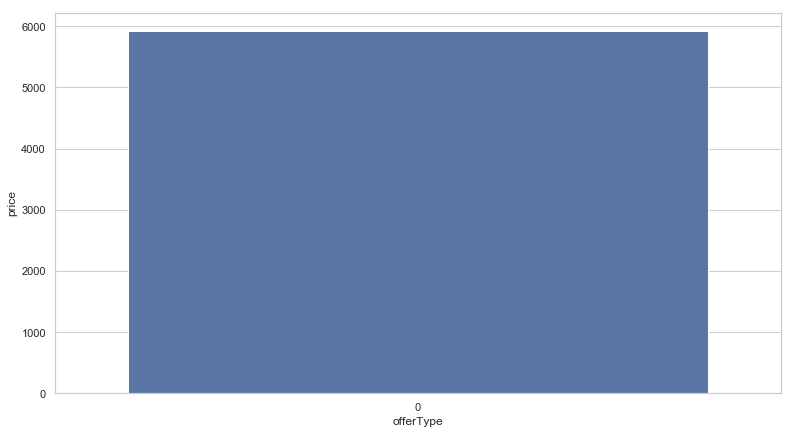

In [24]:
a = train[['offerType', 'price']].groupby(['offerType']).mean().reset_index()
sns.barplot(x='offerType', y= 'price', data=a)

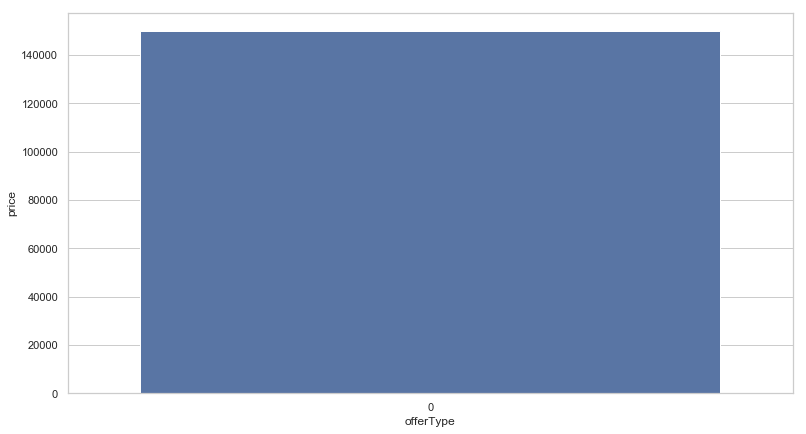

In [25]:
b = train[['offerType', 'price']].groupby(['offerType']).count().reset_index()
sns.barplot(x='offerType', y= 'price', data=b)

## 连续特征与价格可视化

ValueError: max must be larger than min in range parameter.

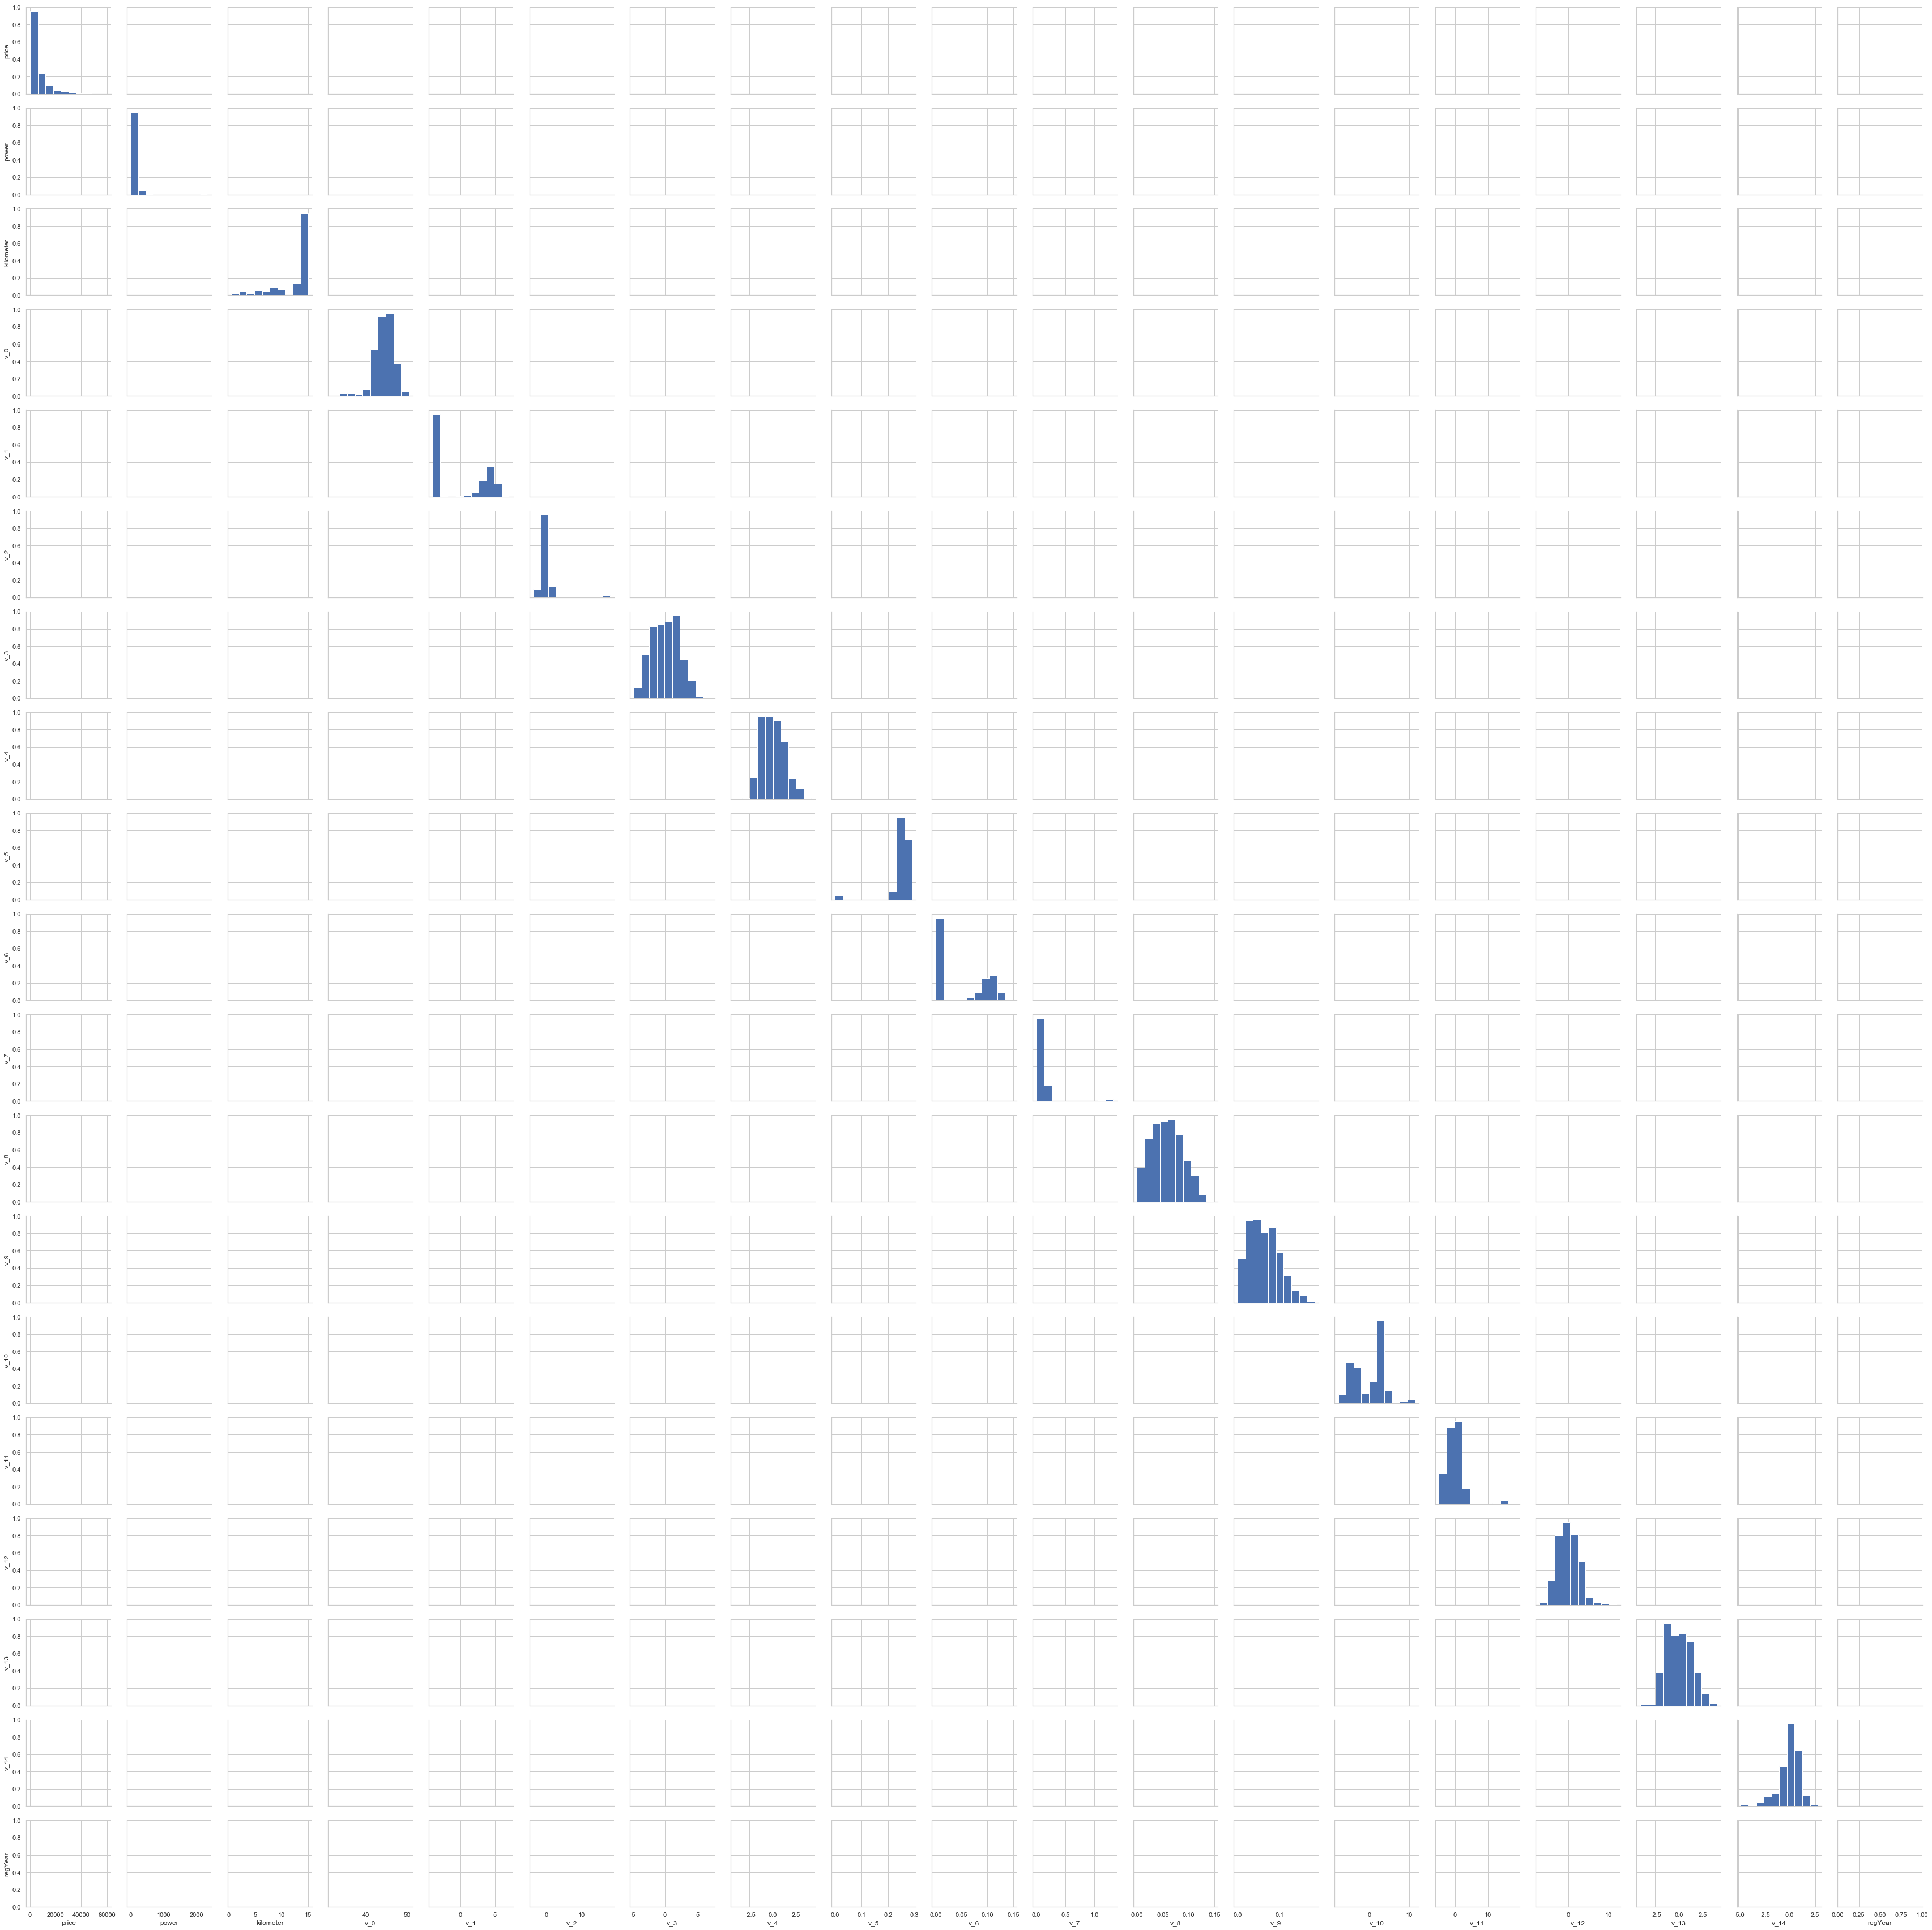

In [26]:
sns.pairplot(data=train.loc[:, ['price', 'power', 'kilometer', 'v_0', 'v_1', 'v_2',
                                'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
                                'v_13', 'v_14', 'regYear']].sample(n=2000, replace=False, random_state=1234))

# 数据特征处理

## 日期脏数据填充

In [4]:
train.drop(['seller', 'offerType'], axis=1, inplace=True)
testA.drop(['seller', 'offerType'], axis=1, inplace=True)

In [5]:
def fill_regDate_month(data):
    year = data.regDate.apply(lambda x: x[:4])
    month = data.regDate.apply(lambda x: x[4:6])
    day = data.regDate.apply(lambda x: x[6:8])
    month_mode = stats.mode(month)[0][0]
    month[month=='00'] = month_mode
    regDateT = year + month + day
    regDateT = regDateT.map(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
    regYearMonth = year + month
    regYearMonth = regYearMonth.map(lambda x: datetime.datetime.strptime(x, '%Y%m'))
    data['regDate'] = regDateT
    data['regYearMonth'] = regYearMonth
    data['creatDate'] = regDateT
    data['creatYearMonth'] = regYearMonth
    return data

train = fill_regDate_month(train)
testA = fill_regDate_month(testA)

In [6]:
####### regYearMonth_hit
merge_regYearMonth = pd.concat([train[['regYearMonth']], testA[['regYearMonth']]], ignore_index=True)
regYearMonth_hit = merge_regYearMonth.regYearMonth.value_counts().reset_index(inplace=False)
regYearMonth_hit.columns = ['regYearMonth', 'regYearMonth_hit']

# regYearMonth_hit一阶差分
sort_regYearMonth_hit = regYearMonth_hit.sort_values(by='regYearMonth', ascending=True)
sort_regYearMonth_hit_diff1 = [0] + list(np.array(sort_regYearMonth_hit.regYearMonth_hit[1:]) - np.array(sort_regYearMonth_hit.regYearMonth_hit[:-1]))
regYearMonth_hit['regYearMonth_hit_diff1'] = sort_regYearMonth_hit_diff1

# regYearMonth_hit十二阶差分
sort_regYearMonth_hit_diff12 = 12*[0] + list(np.array(sort_regYearMonth_hit.regYearMonth_hit[12:]) - np.array(sort_regYearMonth_hit.regYearMonth_hit[:-12]))
regYearMonth_hit['regYearMonth_hit_diff12'] = sort_regYearMonth_hit_diff12

# regYearMonth_hit上一年同比
sort_regYearMonth_hit_tongbi = 12*[1] + list(np.array(sort_regYearMonth_hit.regYearMonth_hit[12:]) / np.array(sort_regYearMonth_hit.regYearMonth_hit[:-12]))
regYearMonth_hit['regYearMonth_hit_tongbi'] = sort_regYearMonth_hit_tongbi

# regYearMonth_hit上一月环比
sort_regYearMonth_hit_huanbi = [1] + list(np.array(sort_regYearMonth_hit.regYearMonth_hit[1:]) / np.array(sort_regYearMonth_hit.regYearMonth_hit[:-1]))
regYearMonth_hit['regYearMonth_hit_huanbi'] = sort_regYearMonth_hit_huanbi
train = train.merge(regYearMonth_hit, how='left', on=['regYearMonth'])
testA = testA.merge(regYearMonth_hit, how='left', on=['regYearMonth'])


####### regYearMonth_price
regYearMonth_price = train.loc[:,['regYearMonth', 'price']].groupby(['regYearMonth']).mean().reset_index(inplace=False)
regYearMonth_price.columns = ['regYearMonth', 'regYearMonth_price']

# regYearMonth_price一阶差分
sort_regYearMonth_price = regYearMonth_price.sort_values(by='regYearMonth', ascending=True)
sort_regYearMonth_price_diff1 = [0] + list(np.array(sort_regYearMonth_price.regYearMonth_price[1:]) - np.array(sort_regYearMonth_price.regYearMonth_price[:-1]))
regYearMonth_price['regYearMonth_price_diff1'] = sort_regYearMonth_price_diff1

# regYearMonth_price十二阶差分
sort_regYearMonth_price_diff12 = 12*[0] + list(np.array(sort_regYearMonth_price.regYearMonth_price[12:]) - np.array(sort_regYearMonth_price.regYearMonth_price[:-12]))
regYearMonth_price['regYearMonth_price_diff12'] = sort_regYearMonth_price_diff12

# regYearMonth_price上一年同比
sort_regYearMonth_price_tongbi = 12*[1] + list(np.array(sort_regYearMonth_price.regYearMonth_price[12:]) / np.array(sort_regYearMonth_price.regYearMonth_price[:-12]))
regYearMonth_price['regYearMonth_price_tongbi'] = sort_regYearMonth_price_tongbi

# regYearMonth_price上一月环比
sort_regYearMonth_price_huanbi = [1] + list(np.array(sort_regYearMonth_price.regYearMonth_price[1:]) / np.array(sort_regYearMonth_price.regYearMonth_price[:-1]))
regYearMonth_price['regYearMonth_price_huanbi'] = sort_regYearMonth_price_huanbi
train = train.merge(regYearMonth_price, how='left', on=['regYearMonth'])
testA = testA.merge(regYearMonth_price, how='left', on=['regYearMonth'])


##### 是否周末
train['regDate_is_Weekend'] = [1 if day in (0,6) else 0 for day in list(train.regDate.apply(lambda x: x.weekday()))]
testA['regDate_is_Weekend'] = [1 if day in (0,6) else 0 for day in list(testA.regDate.apply(lambda x: x.weekday()))]

In [7]:
####### creatYearMonth_hit
merge_creatYearMonth = pd.concat([train[['creatYearMonth']], testA[['creatYearMonth']]], ignore_index=True)
creatYearMonth_hit = merge_creatYearMonth.creatYearMonth.value_counts().reset_index(inplace=False)
creatYearMonth_hit.columns = ['creatYearMonth', 'creatYearMonth_hit']

# creatYearMonth_hit一阶差分
sort_creatYearMonth_hit = creatYearMonth_hit.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_hit_diff1 = [0] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) - np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_diff1'] = sort_creatYearMonth_hit_diff1

# creatYearMonth_hit十二阶差分
sort_creatYearMonth_hit_diff12 = 12*[0] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[12:]) - np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-12]))
creatYearMonth_hit['creatYearMonth_hit_diff12'] = sort_creatYearMonth_hit_diff12

# creatYearMonth_hit上一年同比
sort_creatYearMonth_hit_tongbi = 12*[1] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[12:]) / np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-12]))
creatYearMonth_hit['creatYearMonth_hit_tongbi'] = sort_creatYearMonth_hit_tongbi

# creatYearMonth_hit上一月环比
sort_creatYearMonth_hit_huanbi = [1] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) / np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_huanbi'] = sort_creatYearMonth_hit_huanbi
train = train.merge(creatYearMonth_hit, how='left', on=['creatYearMonth'])
testA = testA.merge(creatYearMonth_hit, how='left', on=['creatYearMonth'])


####### creatYearMonth_price
creatYearMonth_price = train.loc[:,['creatYearMonth', 'price']].groupby(['creatYearMonth']).mean().reset_index(inplace=False)
creatYearMonth_price.columns = ['creatYearMonth', 'creatYearMonth_price']

# creatYearMonth_price一阶差分
sort_creatYearMonth_price = creatYearMonth_price.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_price_diff1 = [0] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) - np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_diff1'] = sort_creatYearMonth_price_diff1

# creatYearMonth_price十二阶差分
sort_creatYearMonth_price_diff12 = 12*[0] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[12:]) - np.array(sort_creatYearMonth_price.creatYearMonth_price[:-12]))
creatYearMonth_price['creatYearMonth_price_diff12'] = sort_creatYearMonth_price_diff12

# creatYearMonth_price上一年同比
sort_creatYearMonth_price_tongbi = 12*[1] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[12:]) / np.array(sort_creatYearMonth_price.creatYearMonth_price[:-12]))
creatYearMonth_price['creatYearMonth_price_tongbi'] = sort_creatYearMonth_price_tongbi

# creatYearMonth_price上一月环比
sort_creatYearMonth_price_huanbi = [1] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) / np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_huanbi'] = sort_creatYearMonth_price_huanbi
train = train.merge(creatYearMonth_price, how='left', on=['creatYearMonth'])
testA = testA.merge(creatYearMonth_price, how='left', on=['creatYearMonth'])


##### 是否周末
train['creatDate_is_Weekend'] = [1 if day in (0,6) else 0 for day in list(train.creatDate.apply(lambda x: x.weekday()))]
testA['creatDate_is_Weekend'] = [1 if day in (0,6) else 0 for day in list(testA.creatDate.apply(lambda x: x.weekday()))]

In [8]:
train.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'regYearMonth', 'creatYearMonth', 'regYearMonth_hit',
       'regYearMonth_hit_diff1', 'regYearMonth_hit_diff12',
       'regYearMonth_hit_tongbi', 'regYearMonth_hit_huanbi',
       'regYearMonth_price', 'regYearMonth_price_diff1',
       'regYearMonth_price_diff12', 'regYearMonth_price_tongbi',
       'regYearMonth_price_huanbi', 'regDate_is_Weekend', 'creatYearMonth_hit',
       'creatYearMonth_hit_diff1', 'creatYearMonth_hit_diff12',
       'creatYearMonth_hit_tongbi', 'creatYearMonth_hit_huanbi',
       'creatYearMonth_price', 'creatYearMonth_price_diff1',
       'creatYearMonth_price_diff12', 'creatYearMonth_price_tongbi',
       'creatYearMonth_price_huanbi', 'creatDate_is_Weeken

In [9]:
testA.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7',
       'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regYearMonth',
       'creatYearMonth', 'regYearMonth_hit', 'regYearMonth_hit_diff1',
       'regYearMonth_hit_diff12', 'regYearMonth_hit_tongbi',
       'regYearMonth_hit_huanbi', 'regYearMonth_price',
       'regYearMonth_price_diff1', 'regYearMonth_price_diff12',
       'regYearMonth_price_tongbi', 'regYearMonth_price_huanbi',
       'regDate_is_Weekend', 'creatYearMonth_hit', 'creatYearMonth_hit_diff1',
       'creatYearMonth_hit_diff12', 'creatYearMonth_hit_tongbi',
       'creatYearMonth_hit_huanbi', 'creatYearMonth_price',
       'creatYearMonth_price_diff1', 'creatYearMonth_price_diff12',
       'creatYearMonth_price_tongbi', 'creatYearMonth_price_huanbi',
       'creatDate_is_Weekend'],
    

## 日期数据转化

In [10]:
# train日期相关

#生成sin/cos特征
train['regWeek_sin'] = np.sin(2 * np.pi * train.regDate.apply(lambda x: x.weekday())/6.0)
train['regWeek_cos'] = np.cos(2 * np.pi * train.regDate.apply(lambda x: x.weekday())/6.0)
train['regMonth_sin'] = np.sin(2 * np.pi * train.regDate.apply(lambda x: x.month)/12.0)
train['regMonth_cos'] = np.cos(2 * np.pi * train.regDate.apply(lambda x: x.month)/12.0)
train['regYear'] = datetime.datetime.now().year - train.regDate.apply(lambda x: x.year)

train['creatWeek_sin'] = np.sin(2 * np.pi * train.creatDate.apply(lambda x: x.weekday())/6.0)
train['creatWeek_cos'] = np.cos(2 * np.pi * train.creatDate.apply(lambda x: x.weekday())/6.0)
train['creatMonth_sin'] = np.sin(2 * np.pi * train.creatDate.apply(lambda x: x.month)/12.0)
train['creatMonth_cos'] = np.cos(2 * np.pi * train.creatDate.apply(lambda x: x.month)/12.0)
train['creatYear'] = datetime.datetime.now().year - train.creatDate.apply(lambda x: x.year)

train['creat_reg_year_diff'] = train.creatDate.apply(lambda x: x.year) - train.regDate.apply(lambda x: x.year)


In [11]:
# test日期相关
#生成sin/cos特征
testA['regWeek_sin'] = np.sin(2 * np.pi * testA.regDate.apply(lambda x: x.weekday())/6.0)
testA['regWeek_cos'] = np.cos(2 * np.pi * testA.regDate.apply(lambda x: x.weekday())/6.0)
testA['regMonth_sin'] = np.sin(2 * np.pi * testA.regDate.apply(lambda x: x.month)/12.0)
testA['regMonth_cos'] = np.cos(2 * np.pi * testA.regDate.apply(lambda x: x.month)/12.0)
testA['regYear'] = datetime.datetime.now().year - testA.regDate.apply(lambda x: x.year)

testA['creatWeek_sin'] = np.sin(2 * np.pi * testA.creatDate.apply(lambda x: x.weekday())/6.0)
testA['creatWeek_cos'] = np.cos(2 * np.pi * testA.creatDate.apply(lambda x: x.weekday())/6.0)
testA['creatMonth_sin'] = np.sin(2 * np.pi * testA.creatDate.apply(lambda x: x.month)/12.0)
testA['creatMonth_cos'] = np.cos(2 * np.pi * testA.creatDate.apply(lambda x: x.month)/12.0)
testA['creatYear'] = datetime.datetime.now().year - testA.creatDate.apply(lambda x: x.year)

testA['creat_reg_year_diff'] = testA.creatDate.apply(lambda x: x.year) - testA.regDate.apply(lambda x: x.year)

In [12]:
# 删除原始日期
train.drop(['regDate', 'creatDate'], axis=1, inplace=True)
testA.drop(['regDate', 'creatDate'], axis=1, inplace=True)

## 合并类别

In [13]:
# fuelType类别合并
train.loc[(train.fuelType==0) | (train.fuelType==2) | (train.fuelType==3) | (train.fuelType==5), ['fuelType']] = 0
train.loc[(train.fuelType==1) | (train.fuelType==4) | (train.fuelType==6), ['fuelType']] = 1

testA.loc[(testA.fuelType==0) | (testA.fuelType==2) | (testA.fuelType==3) | (testA.fuelType==5), ['fuelType']] = 0
testA.loc[(testA.fuelType==1) | (testA.fuelType==4) | (testA.fuelType==6), ['fuelType']] = 1

In [14]:
# bodyType类别合并
train.loc[(train.bodyType==0) | (train.bodyType==2), ['fuelType']] = 0
train.loc[(train.bodyType==4) | (train.bodyType==5), ['fuelType']] = 4

testA.loc[(testA.bodyType==0) | (testA.bodyType==2), ['fuelType']] = 0
testA.loc[(testA.bodyType==4) | (testA.bodyType==5), ['fuelType']] = 4

## 均值编码

In [15]:
# brand_mean_price = train[['brand','price']].groupby(by=['brand']).mean().reset_index()
# brand_mean_price.columns = ['brand','barnd_mean_price_encode']
# train = train.merge(brand_mean_price, on=['brand'], how='left')
# train.drop(labels=['brand'], axis=1, inplace=True)


# testA = testA.merge(brand_mean_price, on=['brand'], how='left')
# testA.drop(labels=['brand'], axis=1, inplace=True)

# train[['barnd_mean_price_encode']].plot.density()

## 分桶

[(0.999, 31.8], (0.999, 31.8], (124.2, 515.0], (0.999, 31.8], (0.999, 31.8], ..., (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0]]
Length: 155
Categories (5, interval[float64]): [(0.999, 31.8] < (31.8, 62.6] < (62.6, 93.4] < (93.4, 124.2] < (124.2, 515.0]]

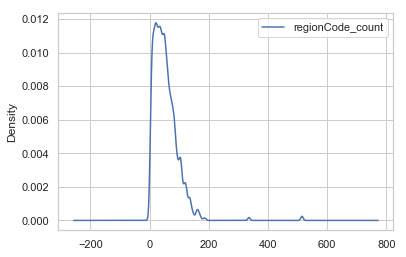

In [16]:
# regionCode
merge_regionCode = pd.concat([train[['regionCode']], testA[['regionCode']]], ignore_index=True)
regionCode_col = merge_regionCode.regionCode.value_counts().reset_index(inplace=False)
regionCode_col.columns = ['regionCode', 'regionCode_count']
train = train.merge(regionCode_col, how='left', on=['regionCode'])
testA = testA.merge(regionCode_col, how='left', on=['regionCode'])
train.drop(['regionCode'], axis=1, inplace=True)
testA.drop(['regionCode'], axis=1, inplace=True)
train[['regionCode_count']].plot.density()

regionCode_count_qcut = pd.qcut(list(set(list(train['regionCode_count']) + list(testA['regionCode_count']))), 5) 
regionCode_count_qcut
train.loc[train.regionCode_count<=31.8, ['regionCode_count']] = 0
train.loc[(31.8<train.regionCode_count) & (train.regionCode_count<=62.6), ['regionCode_count']] = 1
train.loc[(62.6<train.regionCode_count) & (train.regionCode_count<=93.4), ['regionCode_count']] = 2
train.loc[(93.4<train.regionCode_count) & (train.regionCode_count<=124.2), ['regionCode_count']] = 3
train.loc[124.2<train.regionCode_count, ['regionCode_count']] = 4

testA.loc[testA.regionCode_count<=31.8, ['regionCode_count']] = 0
testA.loc[(31.8<testA.regionCode_count) & (testA.regionCode_count<=62.6), ['regionCode_count']] = 1
testA.loc[(62.6<testA.regionCode_count) & (testA.regionCode_count<=93.4), ['regionCode_count']] = 2
testA.loc[(93.4<testA.regionCode_count) & (testA.regionCode_count<=124.2), ['regionCode_count']] = 3
testA.loc[124.2<testA.regionCode_count, ['regionCode_count']] = 4


[(0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], ..., (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0]]
Length: 128
Categories (7, interval[float64]): [(0.999, 19.143] < (19.143, 37.286] < (37.286, 55.429] < (55.429, 75.571] < (75.571, 103.714] < (103.714, 169.0] < (169.0, 378.0]]

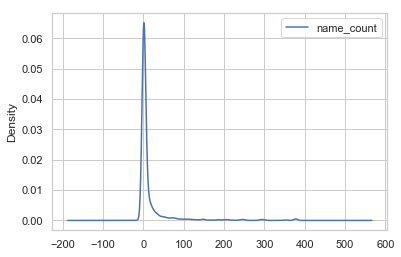

In [17]:
# name
merge_name = pd.concat([train[['name']], testA[['name']]], ignore_index=True)
name_col = merge_name.name.value_counts().reset_index(inplace=False)
name_col.columns = ['name', 'name_count']
train = train.merge(name_col, how='left', on=['name'])
testA = testA.merge(name_col, how='left', on=['name'])
train.drop(['name'], axis=1, inplace=True)
testA.drop(['name'], axis=1, inplace=True)
train[['name_count']].plot.density()

name_count_count_qcut = pd.qcut(list(set(list(train['name_count']) + list(testA['name_count']))), 7) 
name_count_count_qcut
train.loc[train.name_count<=19.143, ['name_count']] = 0
train.loc[(19.143<train.name_count) & (train.name_count<=37.286), ['name_count']] = 1
train.loc[(37.286<train.name_count) & (train.name_count<=55.429), ['name_count']] = 2
train.loc[(55.429<train.name_count) & (train.name_count<=75.571), ['name_count']] = 3 
train.loc[(75.571<train.name_count) & (train.name_count<=103.714), ['name_count']] = 4
train.loc[(103.714<train.name_count) & (train.name_count<=169.0), ['name_count']] = 5 
train.loc[169.0<train.name_count, ['name_count']] = 6

testA.loc[testA.name_count<=19.143, ['name_count']] = 0
testA.loc[(19.143<testA.name_count) & (testA.name_count<=37.286), ['name_count']] = 1
testA.loc[(37.286<testA.name_count) & (testA.name_count<=55.429), ['name_count']] = 2
testA.loc[(55.429<testA.name_count) & (testA.name_count<=75.571), ['name_count']] = 3 
testA.loc[(75.571<testA.name_count) & (testA.name_count<=103.714), ['name_count']] = 4
testA.loc[(103.714<testA.name_count) & (testA.name_count<=169.0), ['name_count']] = 5 
testA.loc[169.0<testA.name_count, ['name_count']] = 6


[NaN, (0.999, 70.714], (0.999, 70.714], (349.857, 559.857], (0.999, 70.714], ..., (349.857, 559.857], (349.857, 559.857], (349.857, 559.857], (559.857, 1606.143], (1606.143, 15658.0]]
Length: 208
Categories (7, interval[float64]): [(0.999, 70.714] < (70.714, 139.571] < (139.571, 216.571] < (216.571, 349.857] < (349.857, 559.857] < (559.857, 1606.143] < (1606.143, 15658.0]]

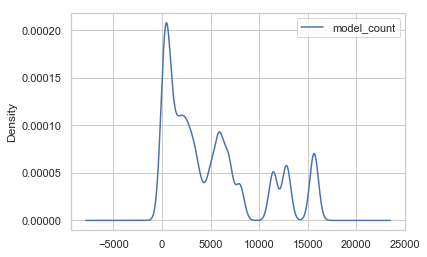

In [18]:
# model
merge_model = pd.concat([train[['model']], testA[['model']]], ignore_index=True)
model_col = merge_model.model.value_counts().reset_index(inplace=False)
model_col.columns = ['model', 'model_count']
train = train.merge(model_col, how='left', on=['model'])
testA = testA.merge(model_col, how='left', on=['model'])
train.drop(['model'], axis=1, inplace=True)
testA.drop(['model'], axis=1, inplace=True)
train[['model_count']].plot.density()


model_count_count_qcut = pd.qcut(list(set(list(train['model_count']) + list(testA['model_count']))), 7) 
model_count_count_qcut

train.loc[train.model_count<=70.714, ['model_count']] = 0
train.loc[(70.714<train.model_count) & (train.model_count<=139.571), ['model_count']] = 1
train.loc[(139.571<train.model_count) & (train.model_count<=216.571), ['model_count']] = 2
train.loc[(216.571<train.model_count) & (train.model_count<=349.857), ['model_count']] = 3 
train.loc[(349.857<train.model_count) & (train.model_count<=559.857), ['model_count']] = 4
train.loc[(559.857<train.model_count) & (train.model_count<=1606.143), ['model_count']] = 5 
train.loc[1606.143<train.model_count, ['model_count']] = 6

testA.loc[testA.model_count<=70.714, ['model_count']] = 0
testA.loc[(70.714<testA.model_count) & (testA.model_count<=139.571), ['model_count']] = 1
testA.loc[(139.571<testA.model_count) & (testA.model_count<=216.571), ['model_count']] = 2
testA.loc[(216.571<testA.model_count) & (testA.model_count<=349.857), ['model_count']] = 3 
testA.loc[(349.857<testA.model_count) & (testA.model_count<=559.857), ['model_count']] = 4
testA.loc[(559.857<testA.model_count) & (testA.model_count<=1606.143), ['model_count']] = 5 
testA.loc[1606.143<testA.model_count, ['model_count']] = 6

[(-30.817, 13950.0], (-30.817, 13950.0], (-30.817, 13950.0], (-30.817, 13950.0], (-30.817, 13950.0], ..., (-30.817, 13950.0], (-30.817, 13950.0], (-30.817, 13950.0], (-30.817, 13950.0], (-30.817, 13950.0]]
Length: 39
Categories (3, interval[float64]): [(-30.817, 13950.0] < (13950.0, 27889.0] < (27889.0, 41828.0]]

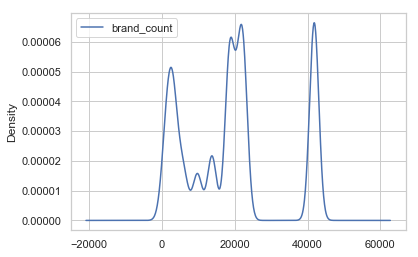

In [19]:
# brand等距分组
merge_brand = pd.concat([train[['brand']], testA[['brand']]], ignore_index=True)
brand_col = merge_brand.brand.value_counts().reset_index(inplace=False)
brand_col.columns = ['brand', 'brand_count']
train = train.merge(brand_col, how='left', on=['brand'])
testA = testA.merge(brand_col, how='left', on=['brand'])
train.drop(['brand'], axis=1, inplace=True)
testA.drop(['brand'], axis=1, inplace=True)
train[['brand_count']].plot.density()


brand_count_count_cut = pd.cut(list(set(list(train['brand_count']) + list(testA['brand_count']))), 3) 
brand_count_count_cut

train.loc[train.brand_count<=13950.0, ['brand_count']] = 0
train.loc[(13950.0<train.brand_count) & (train.brand_count<=27889.0), ['brand_count']] = 1
train.loc[27889.0<train.brand_count, ['brand_count']] = 2


testA.loc[testA.brand_count<=13950.0, ['brand_count']] = 0
testA.loc[(13950.0<testA.brand_count) & (testA.brand_count<=27889.0), ['brand_count']] = 1
testA.loc[27889.0<testA.brand_count, ['brand_count']] = 2

## 对数处理

In [20]:
train.loc[:,['kilometer']] = train[['kilometer']].apply(lambda x: np.log(x + 1))
testA.loc[:,['kilometer']] = testA[['kilometer']].apply(lambda x: np.log(x + 1))

In [21]:
train.columns

Index(['SaleID', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer',
       'notRepairedDamage', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5',
       'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'regYearMonth', 'creatYearMonth', 'regYearMonth_hit',
       'regYearMonth_hit_diff1', 'regYearMonth_hit_diff12',
       'regYearMonth_hit_tongbi', 'regYearMonth_hit_huanbi',
       'regYearMonth_price', 'regYearMonth_price_diff1',
       'regYearMonth_price_diff12', 'regYearMonth_price_tongbi',
       'regYearMonth_price_huanbi', 'regDate_is_Weekend', 'creatYearMonth_hit',
       'creatYearMonth_hit_diff1', 'creatYearMonth_hit_diff12',
       'creatYearMonth_hit_tongbi', 'creatYearMonth_hit_huanbi',
       'creatYearMonth_price', 'creatYearMonth_price_diff1',
       'creatYearMonth_price_diff12', 'creatYearMonth_price_tongbi',
       'creatYearMonth_price_huanbi', 'creatDate_is_Weekend', 'regWeek_sin',
       'regWeek_cos', 'regMonth_sin', 'regMonth_cos'

# 数据加载

In [22]:
def load_data(train, testA, m_type = 'lgb-model'):
    """
        加载数据，设定数值型和非数值型数据
    """
    # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:
    
    
    cate_feat = ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regYear', 'creatYear', 'regYearMonth', 'creatYearMonth']
    num_feat = [i for i in train.columns if i not in cate_feat + [myid, goal]]
    
    lbl = LabelEncoder()  
    for col in cate_feat:
        train[col] = lbl.fit_transform(train[col].astype(str))
        testA[col] = lbl.fit_transform(testA[col].astype(str))
    if m_type == 'lgb-model':
        for i in cate_feat:
            train[i] = train[i].astype('category')
            testA[i] = testA[i].astype('category')         
    features = num_feat + cate_feat

    return (train,testA,features,cate_feat)

# 调参

In [27]:
print("=> 载入数据中...")
train,test,features,cate_feat = load_data(train=train, testA=testA, m_type='lgb-model')
print("=> 使用LightGBM建模...")
# 重要参数：https://blog.csdn.net/u012969412/article/details/72232524
# https://www.cnblogs.com/TimVerion/p/11436001.html

param_test1 = {
    'max_depth':[7, 8, 9],
#     'num_leaves':[200, 230, 250, 300],
#     'min_child_samples': [5, 10, 15, 20, 25],
#     'min_child_weight':[0.001, 0.002, 0.005, 0.01],
#     'min_child_weight':[0.001, 0.003, 0.005, 0.007],    
#     'bagging_fraction':[0.75, 0.8, 0.85, 0.9],
#     'feature_fraction':[0.75, 0.8, 0.85],
#     'colsample_bytree': [0.6, 0.65, 0.7, 0.75],
#     'subsample': [0.6, 0.65, 0.7, 0.75],
#     'learning_rate':[0.01, 0.02, 0.05],
#     'reg_alpha':[0.1, 0.3, 0.5, 0.6],
#     'reg_lambda':[0.3, 0.5, 0.6],
#     'boosting_type':['dart', 'gbdt'],
#     'num_feature':[25, 30, 35, 40]
    
}


gsearch2 = GridSearchCV(estimator = 
                        lgb.LGBMRegressor(
                                          learning_rate=0.1,
                                          n_estimators=2000,
                                          objective='regression',
                                          nthread=4,
#                                           num_leaves=220,
                                          max_depth=8,
#                                           min_child_samples=5,
#                                           min_child_weight=0.001,
                                          metric='mae',
#                                           subsample=0.8,
#                                           colsample_bytree=0.8,
#                                           reg_alpha=0.5,
#                                           reg_lambda=0.3,
                                          seed=2020), 
                        param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4, iid=False, cv=3)
gsearch2.fit(train[features], np.log(train[goal] + 1), verbose=1, feature_name =features, categorical_feature=cate_feat)
print(gsearch2.best_params_, gsearch2.best_score_)

=> 载入数据中...
=> 使用LightGBM建模...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bodyType', 'creatYear', 'creatYearMonth', 'fuelType', 'gearbox', 'notRepairedDamage', 'regYear', 'regYearMonth']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='mae',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=2000, n_jobs=-1, nthread=4,
                                     num_leaves=31, objective='regression',
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, seed=2020, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid=False, n_jobs=4, param_grid={'max_depth': [7, 8, 9]},
             pre_d

{'max_depth': 9} -0.12590080140290225


In [35]:
print("=> 载入数据中...")
train,test,features,cate_feat = load_data(train=train, testA=testA, m_type='xgb-model')
print("=> 使用XGB建模...")
# 第四步：正则化参数调优
param_test4 = {
#     'min_child_weight':[0.001, 0.1, 1,],
#     'boosting_type':['dart', 'gbtree'],
    'n_estimators':[500,1000, 1500, 2000, 2500]
}

gsearch1 = GridSearchCV(estimator = 
                        XGBRegressor(learning_rate =0.1, 
                                     max_depth = 5,
#                                       n_estimators=500, 
                                      min_child_weight=1,
                                     reg_alpha= 0,
                                     reg_lambda= 1,
                                      gamma=0,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                     boosting_type = 'dart',
                                      objective= 'reg:linear',
                                      nthread=4,
                                     verbose=1,
                                      seed=2020), 
                        param_grid = param_test4, scoring='neg_mean_absolute_error', n_jobs=4, iid=False, cv=3)
evalute_result = gsearch1.fit(train[features], np.log(train[goal] + 1))
print("每次运行结果：",evalute_result)
print(gsearch1.best_params_, gsearch1.best_score_)

=> 载入数据中...
=> 使用XGB建模...
每次运行结果： GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    boosting_type='dart', colsample_bylevel=1,
                                    colsample_bytree=0.8, gamma=0,
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=5, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=1,
                                    nthread=4, objective='reg:linear',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=2020, silent=True,
                                    subsample=0.8, verbose=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': [500, 1000, 1500, 2000, 2500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
  

# 训练与分析

In [28]:
# 参考：https://www.cnblogs.com/lvpengbo/p/8822318.html
# https://mathpretty.com/10649.html
# https://www.cnblogs.com/bjwu/p/9307344.html
# https://stackoverflow.com/questions/49774825/python-lightgbm-cross-validation-how-to-use-lightgbm-cv-for-regression

def modelfit(Regressor, train, test, features, m_type='lgb-model', useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        if m_type=='lgb-model':
            dtrain = lgb.Dataset(data=train[features], label=np.log(train[goal] + 1), 
                                 feature_name =features, categorical_feature=cate_feat)
            lgb_param = Regressor.get_params()
            lgb_cvresult = lgb.cv(lgb_param, 
                              dtrain,
                              num_boost_round=Regressor.get_params()['n_estimators'], 
                              nfold=cv_folds, 
                              metrics='mae',
                              early_stopping_rounds=early_stopping_rounds, 
                              verbose_eval=100, 
                              show_stdv=False, 
                              seed=202001, 
                              callbacks=None,
                              # 回归问题设置为False 
                              stratified=False,
                              shuffle=True,
                              feature_name =features,
                              categorical_feature=cate_feat)
            print(len(lgb_cvresult['l1-mean']))
            Regressor.set_params(n_estimators=len(lgb_cvresult['l1-mean']))
        elif m_type=='xgb-model':
            dtrain = xgb.DMatrix(train[features], np.log(train[goal] + 1))
            xgb_param = Regressor.get_xgb_params()
            xgb_cvresult = xgb.cv(xgb_param, 
                              dtrain,
                              num_boost_round=Regressor.get_params()['n_estimators'], 
                              nfold=cv_folds, 
                              metrics='mae',
                              early_stopping_rounds=early_stopping_rounds, 
                              verbose_eval=100, 
                              show_stdv=False, 
                              seed=202002, 
                              callbacks=None, 
                              shuffle=True)
            Regressor.set_params(n_estimators=xgb_cvresult.shape[0])
        
        
    #Fit the algorithm on the data
    if m_type=='lgb-model':
        Regressor.fit(train[features], np.log(train[goal] + 1), eval_metric='mae',
                      feature_name=features, 
                      categorical_feature=cate_feat)
    elif m_type=='xgb-model':
        Regressor.fit(train[features], np.log(train[goal] + 1), eval_metric='mae')
 
    #Predict training set:
    dtrain_predictions = Regressor.predict(train[features])
 
    #Print model report:
    print("\n=>Model Report")
    print("\n=>train====>mean-absolute-error : %.4g" % mean_absolute_error(train[goal].values, 
                                                             np.exp(dtrain_predictions)-1
                                                            ))
    print("\n=>submission result predict:")
    test_predictions = Regressor.predict(test[features])
    submission = pd.DataFrame({myid: test[myid], goal: np.int64(np.exp(test_predictions) - 1)})

    #Save result
    print("\n=>saving submission csv:")
    if not os.path.exists('result/'):
        os.makedirs('result/')
    submission.to_csv("./result/sample_submit11111.csv", index=False)

    #Save model
    print("\n=>saving model:")
    if m_type=='lgb-model':
        if not os.path.exists('model/'):
            os.makedirs('model/')
        joblib.dump(Regressor, "./model/lgbregressor_model.pkl")
        lgb.plot_importance(Regressor)
    elif m_type=='xgb-model':
        if not os.path.exists('model/'):
            os.makedirs('model/')
        joblib.dump(Regressor, "./model/xgbregressor_model.pkl")
        xgb.plot_importance(Regressor)

    #Plot feature importance 
    print("\n=>Plot feature importance:")
    plt.show()

# 最终结果

=> 载入数据中...
=> 使用LightGBM建模...
[0]	train-mae:7.1586	test-mae:7.1586
[100]	train-mae:0.127176	test-mae:0.143372
[200]	train-mae:0.0992056	test-mae:0.126522
[300]	train-mae:0.0883	test-mae:0.123598
[400]	train-mae:0.0800166	test-mae:0.121792
[500]	train-mae:0.0731242	test-mae:0.120551
[600]	train-mae:0.0674016	test-mae:0.119646
[700]	train-mae:0.0623364	test-mae:0.118931
[800]	train-mae:0.0580266	test-mae:0.118342
[900]	train-mae:0.0542414	test-mae:0.117895
[1000]	train-mae:0.0508116	test-mae:0.117511
[1100]	train-mae:0.0476396	test-mae:0.117163
[1200]	train-mae:0.0449594	test-mae:0.116908
[1300]	train-mae:0.04246	test-mae:0.116665
[1400]	train-mae:0.0401062	test-mae:0.116465
[1500]	train-mae:0.0379828	test-mae:0.116266
[1600]	train-mae:0.036107	test-mae:0.1161
[1700]	train-mae:0.0343422	test-mae:0.115949
[1800]	train-mae:0.0327544	test-mae:0.115805
[1900]	train-mae:0.0312862	test-mae:0.115675
[2000]	train-mae:0.029936	test-mae:0.115577
[2100]	train-mae:0.0286878	test-mae:0.115473
[2200]

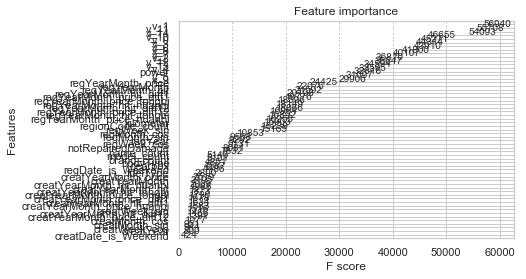

In [29]:
# 第8次提交准备

print("=> 载入数据中...")
train,test,features,cate_feat = load_data(train=train, testA=testA, m_type='xgb-model')
print("=> 使用LightGBM建模...")  

# 第一步：确认学习速率和tree_based
xgb2 = XGBRegressor(
    learning_rate =0.05,
    n_estimators=4000,
    max_depth=9,
    min_child_weight=3,
    reg_alpha= 0.7,
    reg_lambda= 0.1,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.9,
    objective= 'reg:linear',
    nthread=4,
    seed=2020)
   
    
modelfit(xgb2, train, test, features, m_type='xgb-model')

=> 载入数据中...
=> 使用LightGBM建模...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:502: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[100]	cv_agg's l1: 0.14741
[200]	cv_agg's l1: 0.139971
[300]	cv_agg's l1: 0.136444
[400]	cv_agg's l1: 0.134176
[500]	cv_agg's l1: 0.132769
[600]	cv_agg's l1: 0.131577
[700]	cv_agg's l1: 0.130692
[800]	cv_agg's l1: 0.129869
[900]	cv_agg's l1: 0.129299
[1000]	cv_agg's l1: 0.12886
[1100]	cv_agg's l1: 0.128359
[1200]	cv_agg's l1: 0.127923
[1300]	cv_agg's l1: 0.127581
[1400]	cv_agg's l1: 0.127289
[1500]	cv_agg's l1: 0.127056
[1600]	cv_agg's l1: 0.12677
[1700]	cv_agg's l1: 0.126508
[1800]	cv_agg's l1: 0.126308
[1900]	cv_agg's l1: 0.126125
[2000]	cv_agg's l1: 0.125987
[2100]	cv_agg's l1: 0.125813
[2200]	cv_agg's l1: 0.125664
2245


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bodyType', 'creatYear', 'creatYearMonth', 'fuelType', 'gearbox', 'notRepairedDamage', 'regYear', 'regYearMonth']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



=>Model Report

=>train====>mean-absolute-error : 337.2

=>submission result predict:

=>saving submission csv:

=>saving model:

=>Plot feature importance:


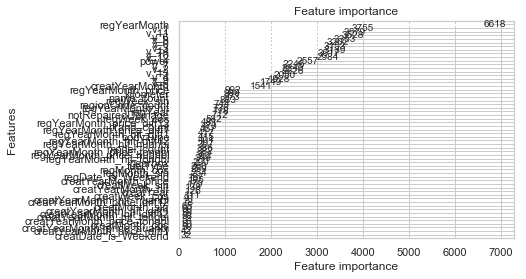

In [25]:
print("=> 载入数据中...")
train,test,features,cate_feat = load_data(train=train, testA=testA, m_type='lgb-model')
print("=> 使用LightGBM建模...")                                         
                                          
lgb1 = LGBMRegressor(
    boosting_type='gbdt', 
    objective='regression', 
    
    n_estimators=3000,

    learning_rate=0.1, 

    subsample=0.8, 
    colsample_bytree=0.8, 
    
    metric='mae')

modelfit(lgb1, train, test, features)



In [159]:
train.notRepairedDamage 

0         0.0
1           -
2         0.0
3         0.0
4         0.0
         ... 
149995    0.0
149996    0.0
149997    0.0
149998    0.0
149999    0.0
Name: notRepairedDamage, Length: 150000, dtype: category
Categories (3, object): [-, 0.0, 1.0]

In [155]:
train.shape

(150000, 62)

In [157]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 61 columns):
SaleID                         50000 non-null int64
bodyType                       48587 non-null category
fuelType                       48326 non-null category
gearbox                        48090 non-null category
power                          50000 non-null int64
kilometer                      50000 non-null float64
notRepairedDamage              50000 non-null category
v_0                            50000 non-null float64
v_1                            50000 non-null float64
v_2                            50000 non-null float64
v_3                            50000 non-null float64
v_4                            50000 non-null float64
v_5                            50000 non-null float64
v_6                            50000 non-null float64
v_7                            50000 non-null float64
v_8                            50000 non-null float64
v_9                        

=> 载入数据中...
=> 使用LightGBM建模...
[100]	cv_agg's l1: 0.13531
[200]	cv_agg's l1: 0.130743
[300]	cv_agg's l1: 0.128908
[400]	cv_agg's l1: 0.127524
[500]	cv_agg's l1: 0.126224
[600]	cv_agg's l1: 0.125388
[700]	cv_agg's l1: 0.124551
[800]	cv_agg's l1: 0.124018
[900]	cv_agg's l1: 0.123463
[1000]	cv_agg's l1: 0.122885
[1100]	cv_agg's l1: 0.122442
[1200]	cv_agg's l1: 0.122093
[1300]	cv_agg's l1: 0.121748
[1400]	cv_agg's l1: 0.121449
[1500]	cv_agg's l1: 0.121185
[1600]	cv_agg's l1: 0.120882
[1700]	cv_agg's l1: 0.120716
[1800]	cv_agg's l1: 0.1205
[1900]	cv_agg's l1: 0.120334
[2000]	cv_agg's l1: 0.120243
[2100]	cv_agg's l1: 0.120111
[2200]	cv_agg's l1: 0.119997
[2300]	cv_agg's l1: 0.119895
[2400]	cv_agg's l1: 0.119786
[2500]	cv_agg's l1: 0.119705
[2600]	cv_agg's l1: 0.119593
[2700]	cv_agg's l1: 0.11949
[2800]	cv_agg's l1: 0.119423
[2900]	cv_agg's l1: 0.119349
[3000]	cv_agg's l1: 0.119292
3000

=>Model Report

=>train====>mean-absolute-error : 183.5

=>submission result predict:

=>saving submission

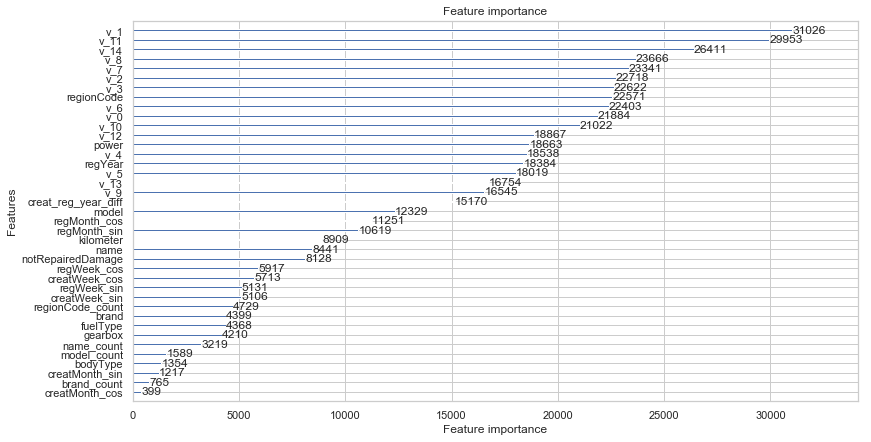

In [122]:
print("=> 载入数据中...")
train,test,features,cate_feat = load_data(train=train, testA=testA, m_type='lgb-model')
print("=> 使用LightGBM建模...")                                         
                                          
lgb1 = LGBMRegressor(
    boosting_type='gbdt', 
    objective='regression', 
    
    n_estimators=3000,
    num_feature=30,

    learning_rate=0.05, 
    max_depth=9,
    num_leaves=220,
    min_child_weight=0.001,
    min_child_samples=5,

    subsample=0.8, 
    colsample_bytree=0.8, 
    
    reg_alpha=0.5,
    reg_lambda=0.3,
    
    metric='mae')

modelfit(lgb1, train, test, features)

=> 载入数据中...
=> 使用LightGBM建模...
[100]	cv_agg's l1: 0.139707
[200]	cv_agg's l1: 0.134603
[300]	cv_agg's l1: 0.132686
[400]	cv_agg's l1: 0.131013
[500]	cv_agg's l1: 0.129962
[600]	cv_agg's l1: 0.129208
[700]	cv_agg's l1: 0.128552
[800]	cv_agg's l1: 0.128094
[900]	cv_agg's l1: 0.127594
[1000]	cv_agg's l1: 0.12716
[1100]	cv_agg's l1: 0.126861
[1200]	cv_agg's l1: 0.126498
[1300]	cv_agg's l1: 0.126293
[1400]	cv_agg's l1: 0.126169
[1500]	cv_agg's l1: 0.126048
[1600]	cv_agg's l1: 0.125889
[1700]	cv_agg's l1: 0.125764
[1800]	cv_agg's l1: 0.125603
[1900]	cv_agg's l1: 0.125523
1938

=>Model Report

=>train====>mean-absolute-error : 219.7

=>submission result predict:

=>saving submission csv:

=>saving model:

=>Plot feature importance:


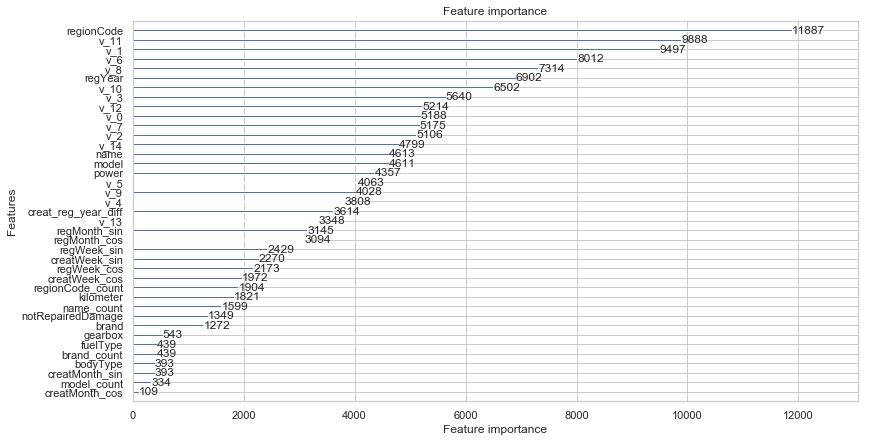

In [101]:
print("=> 载入数据中...")
train,test,features,cate_feat = load_data(train=train, testA=testA, m_type='lgb-model')
print("=> 使用LightGBM建模...")

# lgb1 = LGBMRegressor(
#     learning_rate=0.05,
#     n_estimators=10,
#     objective='regression',
#     nthread=4,
#     num_leaves=220,
#     max_depth=8,
#     min_child_weight=0.001,
#     metric='mae',
#     subsample=0.75,
#     colsample_bytree=0.75,
#     bagging_fraction = 0.75,
#     feature_fraction = 0.75,
#     reg_alpha=0.5,
#     reg_lambda=0.7)

lgb1 = LGBMRegressor(
    boosting_type='gbdt', 
    objective='regression', 
    
    n_estimators=5000,

    learning_rate=0.1, 
    num_leaves=80, 
    max_depth=8,

    subsample=0.8, 
    colsample_bytree=0.8, 
    
    metric='mae')

modelfit(lgb1, train, test, features)

# Lightgbm

In [68]:
def LGBM_native(train,test,features,features_non_numeric):

    
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'max_depth': 13,
        'learning_rate': 0.02,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print("Running with params: " + str(params))
    print("Running with features: " + str(features))

    # Train model with local split
    tsize = 0.05
    df_train, df_test = train_test_split(train, test_size=tsize)
    y_train = np.log(df_train[goal] + 1).values
    y_test = np.log(df_test[goal] + 1).values
    X_train = df_train[features].values
    X_test = df_test[features].values
    
    # 构建lgb中的Dataset格式
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # 训练
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=5000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=50)

    # # 保存模型
    # print('保存模型...')
    # # 保存模型到文件中
    # gbm.save_model('../../tmp/model.txt')

    # Predict and Export
    # 验证集
    test_probs = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    indices = test_probs < 0
    test_probs[indices] = 0
    submission = pd.DataFrame({myid: df_test[myid], goal: np.int64(np.exp(test_probs) - 1), 'true': df_test[goal]})
    
    # 线上的测试集
#     test_probs = gbm.predict(test[features].values, num_iteration=gbm.best_iteration)
#     indices = test_probs < 0
#     test_probs[indices] = 0
#     submission = pd.DataFrame({myid: test[myid], goal: np.int64(np.exp(test_probs) - 1)})

    
    if not os.path.exists('LGBMresult/'):
        os.makedirs('LGBMresult/')
    submission.to_csv("./LGBMresult/dat-lgbm.csv", index=False)


In [69]:
print("=> 载入数据中...")
train,test,features,features_non_numeric = load_data(train=train, testA=testA)
print("=> 处理数据与特征工程...")
train,test,features,features_non_numeric = process_data(train,test,features,features_non_numeric)
print("=> 使用LightGBM建模...")
LGBM_native(train,test,features,features_non_numeric)

=> 载入数据中...
=> 处理数据与特征工程...
=> 使用LightGBM建模...
Running with params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l1', 'l2'}, 'max_depth': 13, 'learning_rate': 0.02, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0}
Running with features: ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regWeek_sin', 'regWeek_cos', 'regMonth_sin', 'regMonth_cos', 'regYear', 'creatWeek_sin', 'creatWeek_cos', 'creatMonth_sin', 'creatMonth_cos', 'creatYear', 'creat_reg_year_diff', 'bodyType0.0', 'bodyType1.0', 'bodyType2.0', 'bodyType3.0', 'bodyType4.0', 'bodyType5.0', 'bodyType6.0', 'bodyType7.0', 'fuelType0.0', 'fuelType1.0', 'fuelType4.0', 'gearbox0.0', 'gearbox1.0', 'notRepairedDamage-', 'notRepairedDamage0.0', 'notRepairedDamage1.0', 'regionCode_count', 'name_count', 'model_count', 'brand_count']
[1]	valid_0's l1: 0.969085	valid_0's l2: 1.41119
Trai

[153]	valid_0's l1: 0.177078	valid_0's l2: 0.071245
[154]	valid_0's l1: 0.176586	valid_0's l2: 0.0709943
[155]	valid_0's l1: 0.176033	valid_0's l2: 0.0707284
[156]	valid_0's l1: 0.175497	valid_0's l2: 0.0704497
[157]	valid_0's l1: 0.174982	valid_0's l2: 0.0701904
[158]	valid_0's l1: 0.174487	valid_0's l2: 0.0699548
[159]	valid_0's l1: 0.173903	valid_0's l2: 0.0696631
[160]	valid_0's l1: 0.173389	valid_0's l2: 0.0694178
[161]	valid_0's l1: 0.172885	valid_0's l2: 0.0691551
[162]	valid_0's l1: 0.172426	valid_0's l2: 0.0689221
[163]	valid_0's l1: 0.171959	valid_0's l2: 0.0686886
[164]	valid_0's l1: 0.171513	valid_0's l2: 0.0684593
[165]	valid_0's l1: 0.171044	valid_0's l2: 0.0682303
[166]	valid_0's l1: 0.170656	valid_0's l2: 0.0680312
[167]	valid_0's l1: 0.170223	valid_0's l2: 0.0678235
[168]	valid_0's l1: 0.169843	valid_0's l2: 0.0676315
[169]	valid_0's l1: 0.16947	valid_0's l2: 0.0674396
[170]	valid_0's l1: 0.16911	valid_0's l2: 0.067277
[171]	valid_0's l1: 0.168706	valid_0's l2: 0.06709

[315]	valid_0's l1: 0.146079	valid_0's l2: 0.0557537
[316]	valid_0's l1: 0.146041	valid_0's l2: 0.0557249
[317]	valid_0's l1: 0.146004	valid_0's l2: 0.0556953
[318]	valid_0's l1: 0.145919	valid_0's l2: 0.0556594
[319]	valid_0's l1: 0.145888	valid_0's l2: 0.0556385
[320]	valid_0's l1: 0.145843	valid_0's l2: 0.0556185
[321]	valid_0's l1: 0.145778	valid_0's l2: 0.0555982
[322]	valid_0's l1: 0.145699	valid_0's l2: 0.0555683
[323]	valid_0's l1: 0.145653	valid_0's l2: 0.0555315
[324]	valid_0's l1: 0.145597	valid_0's l2: 0.0555137
[325]	valid_0's l1: 0.145532	valid_0's l2: 0.0554818
[326]	valid_0's l1: 0.145465	valid_0's l2: 0.0554484
[327]	valid_0's l1: 0.14541	valid_0's l2: 0.0554157
[328]	valid_0's l1: 0.145351	valid_0's l2: 0.0553916
[329]	valid_0's l1: 0.145297	valid_0's l2: 0.0553606
[330]	valid_0's l1: 0.145242	valid_0's l2: 0.0553276
[331]	valid_0's l1: 0.145193	valid_0's l2: 0.0552908
[332]	valid_0's l1: 0.145103	valid_0's l2: 0.0552388
[333]	valid_0's l1: 0.145066	valid_0's l2: 0.05

[483]	valid_0's l1: 0.137796	valid_0's l2: 0.0517045
[484]	valid_0's l1: 0.137756	valid_0's l2: 0.0516866
[485]	valid_0's l1: 0.13775	valid_0's l2: 0.0516848
[486]	valid_0's l1: 0.137704	valid_0's l2: 0.0516666
[487]	valid_0's l1: 0.137634	valid_0's l2: 0.051631
[488]	valid_0's l1: 0.137604	valid_0's l2: 0.0516087
[489]	valid_0's l1: 0.137566	valid_0's l2: 0.0515935
[490]	valid_0's l1: 0.137523	valid_0's l2: 0.0515816
[491]	valid_0's l1: 0.137503	valid_0's l2: 0.0515793
[492]	valid_0's l1: 0.137464	valid_0's l2: 0.0515573
[493]	valid_0's l1: 0.137422	valid_0's l2: 0.0515342
[494]	valid_0's l1: 0.137389	valid_0's l2: 0.0515206
[495]	valid_0's l1: 0.137345	valid_0's l2: 0.0514962
[496]	valid_0's l1: 0.137326	valid_0's l2: 0.0515003
[497]	valid_0's l1: 0.137303	valid_0's l2: 0.0514929
[498]	valid_0's l1: 0.137282	valid_0's l2: 0.0514864
[499]	valid_0's l1: 0.13726	valid_0's l2: 0.0514785
[500]	valid_0's l1: 0.137171	valid_0's l2: 0.0514501
[501]	valid_0's l1: 0.137131	valid_0's l2: 0.0514

[645]	valid_0's l1: 0.133867	valid_0's l2: 0.0499902
[646]	valid_0's l1: 0.13385	valid_0's l2: 0.0499781
[647]	valid_0's l1: 0.133823	valid_0's l2: 0.049959
[648]	valid_0's l1: 0.133776	valid_0's l2: 0.0499428
[649]	valid_0's l1: 0.13377	valid_0's l2: 0.0499409
[650]	valid_0's l1: 0.133753	valid_0's l2: 0.0499362
[651]	valid_0's l1: 0.133737	valid_0's l2: 0.0499376
[652]	valid_0's l1: 0.133723	valid_0's l2: 0.0499208
[653]	valid_0's l1: 0.133701	valid_0's l2: 0.0499159
[654]	valid_0's l1: 0.133692	valid_0's l2: 0.0499141
[655]	valid_0's l1: 0.133675	valid_0's l2: 0.0499059
[656]	valid_0's l1: 0.133653	valid_0's l2: 0.0498919
[657]	valid_0's l1: 0.133644	valid_0's l2: 0.0498888
[658]	valid_0's l1: 0.133602	valid_0's l2: 0.049874
[659]	valid_0's l1: 0.133599	valid_0's l2: 0.0498726
[660]	valid_0's l1: 0.133564	valid_0's l2: 0.049865
[661]	valid_0's l1: 0.133543	valid_0's l2: 0.0498543
[662]	valid_0's l1: 0.133516	valid_0's l2: 0.0498422
[663]	valid_0's l1: 0.133473	valid_0's l2: 0.049822

[818]	valid_0's l1: 0.130939	valid_0's l2: 0.0488454
[819]	valid_0's l1: 0.130938	valid_0's l2: 0.0488405
[820]	valid_0's l1: 0.130926	valid_0's l2: 0.0488351
[821]	valid_0's l1: 0.130917	valid_0's l2: 0.04883
[822]	valid_0's l1: 0.130882	valid_0's l2: 0.0488173
[823]	valid_0's l1: 0.130875	valid_0's l2: 0.0488123
[824]	valid_0's l1: 0.130855	valid_0's l2: 0.0488021
[825]	valid_0's l1: 0.130846	valid_0's l2: 0.0487976
[826]	valid_0's l1: 0.130834	valid_0's l2: 0.0488003
[827]	valid_0's l1: 0.130797	valid_0's l2: 0.0487936
[828]	valid_0's l1: 0.130795	valid_0's l2: 0.0487979
[829]	valid_0's l1: 0.130784	valid_0's l2: 0.0487958
[830]	valid_0's l1: 0.13075	valid_0's l2: 0.04879
[831]	valid_0's l1: 0.130717	valid_0's l2: 0.0487793
[832]	valid_0's l1: 0.130683	valid_0's l2: 0.0487669
[833]	valid_0's l1: 0.13066	valid_0's l2: 0.0487584
[834]	valid_0's l1: 0.130617	valid_0's l2: 0.0487457
[835]	valid_0's l1: 0.130605	valid_0's l2: 0.0487435
[836]	valid_0's l1: 0.130598	valid_0's l2: 0.04874
[

[984]	valid_0's l1: 0.128689	valid_0's l2: 0.048069
[985]	valid_0's l1: 0.128674	valid_0's l2: 0.0480636
[986]	valid_0's l1: 0.128666	valid_0's l2: 0.0480621
[987]	valid_0's l1: 0.128654	valid_0's l2: 0.0480543
[988]	valid_0's l1: 0.128639	valid_0's l2: 0.0480455
[989]	valid_0's l1: 0.128632	valid_0's l2: 0.0480469
[990]	valid_0's l1: 0.128627	valid_0's l2: 0.048044
[991]	valid_0's l1: 0.128627	valid_0's l2: 0.048046
[992]	valid_0's l1: 0.128598	valid_0's l2: 0.0480378
[993]	valid_0's l1: 0.12859	valid_0's l2: 0.0480354
[994]	valid_0's l1: 0.128584	valid_0's l2: 0.048039
[995]	valid_0's l1: 0.128575	valid_0's l2: 0.0480349
[996]	valid_0's l1: 0.128551	valid_0's l2: 0.0480263
[997]	valid_0's l1: 0.128529	valid_0's l2: 0.0480155
[998]	valid_0's l1: 0.128508	valid_0's l2: 0.0480042
[999]	valid_0's l1: 0.128505	valid_0's l2: 0.0480062
[1000]	valid_0's l1: 0.128482	valid_0's l2: 0.0479959
[1001]	valid_0's l1: 0.128465	valid_0's l2: 0.0479878
[1002]	valid_0's l1: 0.128461	valid_0's l2: 0.047

[1147]	valid_0's l1: 0.127081	valid_0's l2: 0.047529
[1148]	valid_0's l1: 0.127067	valid_0's l2: 0.0475228
[1149]	valid_0's l1: 0.127064	valid_0's l2: 0.0475224
[1150]	valid_0's l1: 0.127057	valid_0's l2: 0.0475188
[1151]	valid_0's l1: 0.127045	valid_0's l2: 0.0475181
[1152]	valid_0's l1: 0.127027	valid_0's l2: 0.047511
[1153]	valid_0's l1: 0.127023	valid_0's l2: 0.0475144
[1154]	valid_0's l1: 0.127007	valid_0's l2: 0.0475066
[1155]	valid_0's l1: 0.126999	valid_0's l2: 0.047503
[1156]	valid_0's l1: 0.126998	valid_0's l2: 0.047505
[1157]	valid_0's l1: 0.126994	valid_0's l2: 0.0475028
[1158]	valid_0's l1: 0.126989	valid_0's l2: 0.0474976
[1159]	valid_0's l1: 0.126985	valid_0's l2: 0.0474938
[1160]	valid_0's l1: 0.126981	valid_0's l2: 0.0474951
[1161]	valid_0's l1: 0.126968	valid_0's l2: 0.0474921
[1162]	valid_0's l1: 0.126959	valid_0's l2: 0.0474871
[1163]	valid_0's l1: 0.126952	valid_0's l2: 0.0474851
[1164]	valid_0's l1: 0.126941	valid_0's l2: 0.0474802
[1165]	valid_0's l1: 0.126933	va

[1304]	valid_0's l1: 0.125881	valid_0's l2: 0.0471371
[1305]	valid_0's l1: 0.125875	valid_0's l2: 0.0471381
[1306]	valid_0's l1: 0.12587	valid_0's l2: 0.0471377
[1307]	valid_0's l1: 0.125864	valid_0's l2: 0.047138
[1308]	valid_0's l1: 0.125865	valid_0's l2: 0.0471399
[1309]	valid_0's l1: 0.125853	valid_0's l2: 0.0471329
[1310]	valid_0's l1: 0.125848	valid_0's l2: 0.0471318
[1311]	valid_0's l1: 0.125839	valid_0's l2: 0.0471306
[1312]	valid_0's l1: 0.125822	valid_0's l2: 0.047123
[1313]	valid_0's l1: 0.125815	valid_0's l2: 0.0471173
[1314]	valid_0's l1: 0.125815	valid_0's l2: 0.047122
[1315]	valid_0's l1: 0.125812	valid_0's l2: 0.0471204
[1316]	valid_0's l1: 0.125814	valid_0's l2: 0.0471187
[1317]	valid_0's l1: 0.125805	valid_0's l2: 0.0471129
[1318]	valid_0's l1: 0.125798	valid_0's l2: 0.0471113
[1319]	valid_0's l1: 0.125794	valid_0's l2: 0.0471082
[1320]	valid_0's l1: 0.125793	valid_0's l2: 0.0471055
[1321]	valid_0's l1: 0.125789	valid_0's l2: 0.0471078
[1322]	valid_0's l1: 0.125793	va

[1462]	valid_0's l1: 0.124621	valid_0's l2: 0.0466751
[1463]	valid_0's l1: 0.12462	valid_0's l2: 0.0466756
[1464]	valid_0's l1: 0.124622	valid_0's l2: 0.0466703
[1465]	valid_0's l1: 0.124616	valid_0's l2: 0.0466586
[1466]	valid_0's l1: 0.124599	valid_0's l2: 0.046652
[1467]	valid_0's l1: 0.124586	valid_0's l2: 0.0466502
[1468]	valid_0's l1: 0.124575	valid_0's l2: 0.0466474
[1469]	valid_0's l1: 0.124555	valid_0's l2: 0.0466434
[1470]	valid_0's l1: 0.124544	valid_0's l2: 0.0466357
[1471]	valid_0's l1: 0.124535	valid_0's l2: 0.0466307
[1472]	valid_0's l1: 0.124525	valid_0's l2: 0.0466244
[1473]	valid_0's l1: 0.124516	valid_0's l2: 0.0466216
[1474]	valid_0's l1: 0.124506	valid_0's l2: 0.0466162
[1475]	valid_0's l1: 0.124496	valid_0's l2: 0.0466147
[1476]	valid_0's l1: 0.124494	valid_0's l2: 0.0466165
[1477]	valid_0's l1: 0.124489	valid_0's l2: 0.0466119
[1478]	valid_0's l1: 0.124482	valid_0's l2: 0.0466059
[1479]	valid_0's l1: 0.124477	valid_0's l2: 0.0466066
[1480]	valid_0's l1: 0.124473	

[1625]	valid_0's l1: 0.123649	valid_0's l2: 0.0463681
[1626]	valid_0's l1: 0.123646	valid_0's l2: 0.0463647
[1627]	valid_0's l1: 0.123636	valid_0's l2: 0.0463563
[1628]	valid_0's l1: 0.12363	valid_0's l2: 0.0463558
[1629]	valid_0's l1: 0.123624	valid_0's l2: 0.046351
[1630]	valid_0's l1: 0.123619	valid_0's l2: 0.0463508
[1631]	valid_0's l1: 0.123612	valid_0's l2: 0.0463518
[1632]	valid_0's l1: 0.123602	valid_0's l2: 0.0463472
[1633]	valid_0's l1: 0.123595	valid_0's l2: 0.0463428
[1634]	valid_0's l1: 0.123596	valid_0's l2: 0.0463473
[1635]	valid_0's l1: 0.123584	valid_0's l2: 0.0463428
[1636]	valid_0's l1: 0.123585	valid_0's l2: 0.0463455
[1637]	valid_0's l1: 0.123589	valid_0's l2: 0.046351
[1638]	valid_0's l1: 0.123591	valid_0's l2: 0.0463544
[1639]	valid_0's l1: 0.123589	valid_0's l2: 0.0463579
[1640]	valid_0's l1: 0.123582	valid_0's l2: 0.0463555
[1641]	valid_0's l1: 0.123587	valid_0's l2: 0.0463615
[1642]	valid_0's l1: 0.123591	valid_0's l2: 0.046365
[1643]	valid_0's l1: 0.123587	va

[1783]	valid_0's l1: 0.122714	valid_0's l2: 0.0460682
[1784]	valid_0's l1: 0.122707	valid_0's l2: 0.0460675
[1785]	valid_0's l1: 0.122686	valid_0's l2: 0.0460636
[1786]	valid_0's l1: 0.122687	valid_0's l2: 0.046064
[1787]	valid_0's l1: 0.122685	valid_0's l2: 0.0460652
[1788]	valid_0's l1: 0.122689	valid_0's l2: 0.0460706
[1789]	valid_0's l1: 0.122689	valid_0's l2: 0.0460719
[1790]	valid_0's l1: 0.122683	valid_0's l2: 0.0460717
[1791]	valid_0's l1: 0.122673	valid_0's l2: 0.0460697
[1792]	valid_0's l1: 0.122666	valid_0's l2: 0.0460687
[1793]	valid_0's l1: 0.122662	valid_0's l2: 0.0460678
[1794]	valid_0's l1: 0.122655	valid_0's l2: 0.0460699
[1795]	valid_0's l1: 0.122648	valid_0's l2: 0.0460687
[1796]	valid_0's l1: 0.122631	valid_0's l2: 0.0460635
[1797]	valid_0's l1: 0.122607	valid_0's l2: 0.0460495
[1798]	valid_0's l1: 0.122597	valid_0's l2: 0.0460483
[1799]	valid_0's l1: 0.122577	valid_0's l2: 0.0460387
[1800]	valid_0's l1: 0.122573	valid_0's l2: 0.0460395
[1801]	valid_0's l1: 0.122572

[1953]	valid_0's l1: 0.122102	valid_0's l2: 0.0459543
[1954]	valid_0's l1: 0.122088	valid_0's l2: 0.0459475
[1955]	valid_0's l1: 0.122077	valid_0's l2: 0.0459435
[1956]	valid_0's l1: 0.122075	valid_0's l2: 0.0459431
[1957]	valid_0's l1: 0.122074	valid_0's l2: 0.0459419
[1958]	valid_0's l1: 0.12207	valid_0's l2: 0.0459392
[1959]	valid_0's l1: 0.122068	valid_0's l2: 0.0459389
[1960]	valid_0's l1: 0.122069	valid_0's l2: 0.0459387
[1961]	valid_0's l1: 0.122054	valid_0's l2: 0.0459337
[1962]	valid_0's l1: 0.122053	valid_0's l2: 0.0459317
[1963]	valid_0's l1: 0.122047	valid_0's l2: 0.0459287
[1964]	valid_0's l1: 0.122044	valid_0's l2: 0.0459305
[1965]	valid_0's l1: 0.122039	valid_0's l2: 0.0459309
[1966]	valid_0's l1: 0.122043	valid_0's l2: 0.0459342
[1967]	valid_0's l1: 0.12204	valid_0's l2: 0.0459333
[1968]	valid_0's l1: 0.122038	valid_0's l2: 0.045932
[1969]	valid_0's l1: 0.122044	valid_0's l2: 0.0459366
[1970]	valid_0's l1: 0.122035	valid_0's l2: 0.0459318
[1971]	valid_0's l1: 0.122031	v

[2111]	valid_0's l1: 0.121388	valid_0's l2: 0.0458207
[2112]	valid_0's l1: 0.121388	valid_0's l2: 0.0458174
[2113]	valid_0's l1: 0.121389	valid_0's l2: 0.0458193
[2114]	valid_0's l1: 0.121384	valid_0's l2: 0.045819
[2115]	valid_0's l1: 0.121377	valid_0's l2: 0.0458151
[2116]	valid_0's l1: 0.121371	valid_0's l2: 0.0458138
[2117]	valid_0's l1: 0.12137	valid_0's l2: 0.0458139
[2118]	valid_0's l1: 0.121371	valid_0's l2: 0.0458158
[2119]	valid_0's l1: 0.121369	valid_0's l2: 0.0458157
[2120]	valid_0's l1: 0.121366	valid_0's l2: 0.0458145
[2121]	valid_0's l1: 0.12136	valid_0's l2: 0.0458127
[2122]	valid_0's l1: 0.121355	valid_0's l2: 0.0458094
[2123]	valid_0's l1: 0.121349	valid_0's l2: 0.0458107
[2124]	valid_0's l1: 0.121344	valid_0's l2: 0.0458083
[2125]	valid_0's l1: 0.121336	valid_0's l2: 0.0458065
[2126]	valid_0's l1: 0.121325	valid_0's l2: 0.045807
[2127]	valid_0's l1: 0.121316	valid_0's l2: 0.0458106
[2128]	valid_0's l1: 0.121314	valid_0's l2: 0.0458126
[2129]	valid_0's l1: 0.121314	va

[2271]	valid_0's l1: 0.120856	valid_0's l2: 0.0457047
[2272]	valid_0's l1: 0.120851	valid_0's l2: 0.045703
[2273]	valid_0's l1: 0.120843	valid_0's l2: 0.045702
[2274]	valid_0's l1: 0.12083	valid_0's l2: 0.0456977
[2275]	valid_0's l1: 0.120829	valid_0's l2: 0.0457042
[2276]	valid_0's l1: 0.120825	valid_0's l2: 0.0457009
[2277]	valid_0's l1: 0.120818	valid_0's l2: 0.0456998
[2278]	valid_0's l1: 0.120806	valid_0's l2: 0.0456979
[2279]	valid_0's l1: 0.120796	valid_0's l2: 0.0456936
[2280]	valid_0's l1: 0.120799	valid_0's l2: 0.0456952
[2281]	valid_0's l1: 0.120802	valid_0's l2: 0.0456968
[2282]	valid_0's l1: 0.120801	valid_0's l2: 0.0456943
[2283]	valid_0's l1: 0.120799	valid_0's l2: 0.0456916
[2284]	valid_0's l1: 0.120794	valid_0's l2: 0.0456887
[2285]	valid_0's l1: 0.120797	valid_0's l2: 0.0456929
[2286]	valid_0's l1: 0.120788	valid_0's l2: 0.0456876
[2287]	valid_0's l1: 0.120789	valid_0's l2: 0.045691
[2288]	valid_0's l1: 0.12078	valid_0's l2: 0.0456863
[2289]	valid_0's l1: 0.120778	val

[2438]	valid_0's l1: 0.12036	valid_0's l2: 0.0456182
[2439]	valid_0's l1: 0.12036	valid_0's l2: 0.0456191
[2440]	valid_0's l1: 0.120352	valid_0's l2: 0.0456157
[2441]	valid_0's l1: 0.120351	valid_0's l2: 0.0456148
[2442]	valid_0's l1: 0.120348	valid_0's l2: 0.0456152
[2443]	valid_0's l1: 0.120344	valid_0's l2: 0.0456156
[2444]	valid_0's l1: 0.12034	valid_0's l2: 0.0456155
[2445]	valid_0's l1: 0.120339	valid_0's l2: 0.0456144
[2446]	valid_0's l1: 0.120338	valid_0's l2: 0.045613
[2447]	valid_0's l1: 0.120333	valid_0's l2: 0.0456106
[2448]	valid_0's l1: 0.120331	valid_0's l2: 0.0456086
[2449]	valid_0's l1: 0.120329	valid_0's l2: 0.0456076
[2450]	valid_0's l1: 0.120332	valid_0's l2: 0.0456138
[2451]	valid_0's l1: 0.120326	valid_0's l2: 0.0456101
[2452]	valid_0's l1: 0.120322	valid_0's l2: 0.0456052
[2453]	valid_0's l1: 0.120322	valid_0's l2: 0.0456028
[2454]	valid_0's l1: 0.120312	valid_0's l2: 0.0456005
[2455]	valid_0's l1: 0.120317	valid_0's l2: 0.0456062
[2456]	valid_0's l1: 0.120314	va

# 验证结果

In [151]:
res = pd.read_csv('result/dat-xgb_d10_eta0.01_ntree800_mcw3_tsize0.05.csv')
np.mean(abs(res.price-res.true))

551.2745333333334

In [156]:
res = pd.read_csv('result/dat-xgb_d10_eta0.01_ntree467_mcw3_tsize0.05.csv')
np.mean(abs(res.price-res.true))

783.6193333333333

In [202]:
res = pd.read_csv('result/dat-xgb_d12_eta0.01_ntree800_mcw3_tsize0.05.csv')
np.mean(abs(res.price-res.true))

546.95

In [224]:
# brand不做任何处理
res = pd.read_csv('result/dat-xgb_d12_eta0.01_ntree800_mcw3_tsize0.05.csv')
np.mean(abs(res.price-res.true))

510.63826666666665

In [86]:
# brand采用均值编码变得更差了
res = pd.read_csv('result/dat-xgb_d12_eta0.01_ntree800_mcw3_tsize0.05.csv')
np.mean(abs(res.price-res.true))

562.8721333333333

In [96]:
# 换回xgb，增加归类合并
res = pd.read_csv('result/dat-xgb_d12_eta0.01_ntree800_mcw3_tsize0.05.csv')
np.mean(abs(res.price-res.true))

528.1073333333334

In [159]:
# 换回xgb，增加归类合并、去特征、分桶
res = pd.read_csv('result/dat-xgb_d12_eta0.01_ntree800_mcw3_tsize0.05.csv')
np.mean(abs(res.price-res.true))

526.8973333333333

In [24]:
resxgb = pd.read_csv('result/dat-xgb_d12_eta0.01_ntree800_mcw3_tsize0.05.csv')
np.mean(abs(resxgb.price-resxgb.true))

518.6076

In [72]:
reslgb = pd.read_csv('LGBMresult/dat-lgbm.csv')
np.mean(abs(reslgb.price-reslgb.true))

538.0776

In [74]:
np.mean(abs((reslgb.price+resxgb.price)/2 - reslgb.true))

3244.272

In [52]:
reslgb = pd.read_csv('LGBMresult/dat-lgbm.csv')
reslgb.head()

,SaleID,price
0,150000,30759
1,150001,349
2,150002,4942
3,150003,10751
4,150004,659


In [55]:
resxgb2 = pd.read_csv('result/sample_submit2.csv')
resxgb3 = pd.read_csv('result/sample_submit3.csv')
np.mean(abs(resxgb2.price - resxgb3.price))

328.5628

In [57]:
resxgb5 = pd.read_csv('result/sample_submit5.csv')
np.mean(abs(resxgb2.price - resxgb5.price))

286.34426

In [58]:
resxgb6 = pd.read_csv('result/sample_submit11111.csv')
np.mean(abs(resxgb2.price - resxgb6.price))

270.78342

In [59]:
np.mean(abs(resxgb5.price - resxgb6.price))

206.53752

In [117]:
resxgb6 = pd.read_csv('result/sample_submit6.csv')
resxgb7 = pd.read_csv('result/sample_submit11111.csv')
np.mean(abs(resxgb6.price - resxgb7.price))

281.89954

In [121]:
resxgb6 = pd.read_csv('result/sample_submit6.csv')
resxgb7 = pd.read_csv('result/sample_submit11111.csv')
np.mean(abs(resxgb6.price - resxgb7.price))

281.6161

In [123]:
resxgb6 = pd.read_csv('result/sample_submit6.csv')
resxgb7 = pd.read_csv('result/sample_submit11111.csv')
np.mean(abs(resxgb6.price - resxgb7.price))

282.04068

In [64]:
result = pd.DataFrame({myid:reslgb.SaleID, goal:np.int64((reslgb.price + resxgb0.price)/2)})
np.mean(abs(resxgb1.price - result.price))

351.05176

In [30]:
resxgb6 = pd.read_csv('result/sample_submit6.csv')
resxgb8 = pd.read_csv('result/sample_submit11111.csv')
np.mean(abs(resxgb6.price - resxgb8.price))

182.746

In [20]:
res1 = pd.read_csv('result/sample_submit2.csv')
res0 = pd.read_csv('result/sample_submit.csv')
np.mean(abs(res1.price-res0.price))

95.3896

In [106]:
res3 = pd.read_csv('result/sample_submit3.csv')
np.mean(abs(res3.price-submission.price))

231.20324

In [160]:
res3 = pd.read_csv('result/sample_submit3.csv')
np.mean(abs(res3.price-submission.price))

284.7450171972837

# 预测很差的数据

In [175]:
res = pd.read_csv('result/dat-xgb_d12_eta0.01_ntree800_mcw3_tsize0.05.csv')
bad_res = res[abs(res.price-res.true)>500][['SaleID']]
detail = train.merge(bad_res, on=['SaleID'], how='inner')

In [180]:
detail.head()

,SaleID,brand,power,kilometer,price,v_0,v_1,v_2,v_3,v_4,...,fuelType3.0,fuelType5.0,notRepairedDamage0.0,notRepairedDamage1.0,seller0,seller1,offerType0,regionCode_count,name_count,model_count
0,217,10,193,12.5,2300,44.798793,3.720426,-0.473669,2.074723,-1.092440,...,0,0,1,0,1,0,1,0,0,6.0
1,352,0,200,10.0,10500,46.935306,5.251274,0.620973,-1.244831,-0.112119,...,0,0,0,1,1,0,1,2,4,6.0
2,379,10,70,12.5,23500,47.601523,-3.209717,-0.661713,-2.603298,-2.576929,...,0,0,1,0,1,0,1,0,0,1.0
3,440,15,136,2.0,19700,47.446725,-3.196781,0.745330,-3.625962,-0.123710,...,0,0,1,0,1,0,1,1,0,5.0
4,445,4,192,15.0,8300,45.709143,4.235664,0.274718,0.485756,-1.346011,...,0,0,1,0,1,0,1,0,0,6.0


In [75]:
resxgb.head()

,SaleID,price,true
0,125493,47089,51000
1,107672,3670,3690
2,78310,9455,9700
3,8495,3464,3499
4,115076,12209,13200


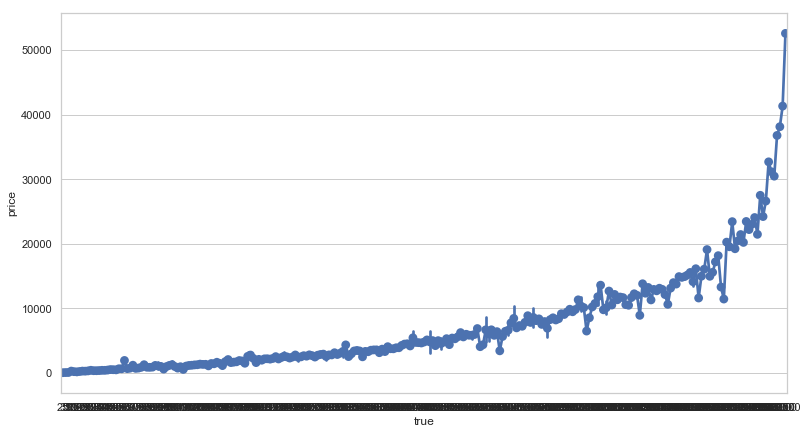

In [79]:
sns.pointplot(x='true', y='price', data=resxgb.sample(n=500, replace=False, random_state=135))

In [104]:
res0 = pd.read_csv('result/sample_submit1.csv')

In [105]:
res1 = pd.read_csv('result/sample_submit2.csv')
high_price = res1[res1.price>10000]
recall_test_high_price = testA.merge(high_price, on=['SaleID'], how='inner')

In [106]:
recall_test_high_price.columns

Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'offerType', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7',
       'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regWeek_sin',
       'regWeek_cos', 'regMonth_sin', 'regMonth_cos', 'regYear',
       'creatWeek_sin', 'creatWeek_cos', 'creatMonth_sin', 'creatMonth_cos',
       'creatYear', 'creat_reg_year_diff', 'price'],
      dtype='object')

In [107]:
recall_test_high_price.shape

(8794, 40)

In [108]:
train_mean_price = train[[ 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'offerType', 'regYear', 'creat_reg_year_diff', 'price']].groupby(by=[ 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'offerType', 'regYear', 'creat_reg_year_diff']).mean()

In [109]:
recall_res = recall_test_high_price.merge(train_mean_price, on=[ 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'offerType', 'regYear', 'creat_reg_year_diff'], how='inner')

In [110]:
recall_res.shape

(348, 41)

In [111]:
recall_res['price'] = np.int64(1/2*recall_res.price_x + 1/2*recall_res.price_y)

In [112]:
modify_submmit = res1.merge(recall_res[['SaleID', 'price']], on=['SaleID'], how='outer')

In [113]:
modify_submmit.head()

,SaleID,price_x,price_y
0,150000,35782,NaN
1,150001,333,NaN
2,150002,6202,NaN
3,150003,11890,NaN
4,150004,636,NaN


In [115]:
modify_submmit.loc[modify_submmit['price_y'].isnull(),'price_y'] = modify_submmit[modify_submmit['price_y'].isnull()]['price_x']

In [98]:
modify_submmit

,SaleID,price_x,price_y
0,150000,35782,35782.0
1,150001,333,333.0
2,150002,6202,6202.0
3,150003,11890,11890.0
4,150004,636,636.0
...,...,...,...
49995,199995,2659,2659.0
49996,199996,1411,1411.0
49997,199997,7902,7902.0
49998,199998,9629,9629.0


In [116]:
np.mean(abs(res0.price - modify_submmit.price_x))

229.74612

In [117]:
np.mean(abs(res0.price - modify_submmit.price_y))

230.05964

In [120]:
modify_submmit['price'] = np.int64(modify_submmit.price_y)
modify_submmit.drop(labels=['price_x', 'price_y'], axis=1, inplace=True)

In [121]:
modify_submmit.head()

,SaleID,price
0,150000,35782
1,150001,333
2,150002,6202
3,150003,11890
4,150004,636


In [122]:
modify_submmit.to_csv("./result/sample_submit.csv", index=False)